# 프로젝트 : Transformer로 번역기 만들기
=============================================================================

## 목차

### 1. 데이터 불러오기
### 2. 데이터 전처리 및 토큰화
### 3. 모델 구성하기
### 4. 모델 학습 및 결과 확인
### 5. 회고
### 6. Reference
### 7. 자기다짐 및 아쉬운 점

---

## 루브릭 달성 조건

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
2. Transformer 번역기 모델이 정상적으로 구동된다.
    - Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.
    
---    

## 1. 데이터 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random
import sentencepiece as spm
from tqdm import tqdm

from konlpy.tag import Mecab
from bs4 import BeautifulSoup 
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, BatchNormalization, LayerNormalization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
ko_path = './data/korean-english-park.train.ko'
eng_path = './data/korean-english-park.train.en'

ko_temp_file = os.getenv('HOME')+'/aiffel/Going_Deeper/10_GD/data/spm_ko.temp'
en_temp_file = os.getenv('HOME')+'/aiffel/Going_Deeper/10_GD/data/spm_en.temp'

In [3]:
kor_corpus = []
eng_corpus = []

count = 0
with open(ko_path, 'r') as k:
    while True:
        sentence = k.readline()        
        kor_corpus.append(sentence)
        count += 1
        if count == 50000:
            break
            
count = 0            
with open(eng_path, 'r') as e:
    while True:
        sentence = e.readline()             
        eng_corpus.append(sentence)
        count += 1
        if count == 50000:
            break          

In [4]:
kor_df = pd.DataFrame(kor_corpus)
eng_df = pd.DataFrame(eng_corpus)

kor_df.rename(columns = {0:'kor_corpus'}, inplace=True)
eng_df.rename(columns = {0:'eng_corpus'}, inplace=True)

df = pd.concat([kor_df, eng_df], axis=1)

In [5]:
df.drop_duplicates(inplace=True)

df.isna().sum()

kor_corpus    0
eng_corpus    0
dtype: int64

In [6]:
df.reset_index(inplace=True, drop=True)

---
## 2. 데이터 전처리 및 토큰화

In [7]:
def clear_sentence(sentence, s_token=False, e_token=False):
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', r'', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[^a-zA-Z가-힣,.?! ]+', r'', sentence)
    sentence = re.sub(r"['\n']+", r"", sentence)
    sentence = re.sub(r'["   "]+', " ", sentence)
    sentence = sentence.lower()
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [8]:
def max_min_len(data, name):
    max_len = 0
    min_len = 999
    total_len = 0

    for i in tqdm(range(len(data))):
        if len(data[i]) < min_len:
            min_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) > max_len:
            max_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) >= min_len or len(data[i]) <= max_len:
            total_len += len(data[i])
    mean_len = total_len//len(data)
    
    print(f'{name} 데이터셋의 최대 길이: {max_len}')
    print(f'{name} 데이터셋의 최소 길이: {min_len}')
    print(f'{name} 데이터셋의 평균 길이: {mean_len}')
    print(f'{name} 데이터셋의 총 길이: {total_len}')
    print('----'*32)
    
    sentence_length = np.zeros((max_len), dtype=np.int)

    for s in data:
        sentence_length[len(s)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("{} Length".format(name))
    plt.show()

In [9]:
def length_sentence(corpus, min_num = 0, max_num = 25000, name=None):
    corpus_len = len(corpus)
    for i in tqdm(range(corpus_len)):
        if len(corpus[i]) <= min_num or len(corpus[i]) > max_num:
            corpus[i] = np.nan
        else:
            corpus[i] = corpus[i]
    
    return corpus

In [10]:
for idx, sentence in enumerate(tqdm(df['kor_corpus'])):
    sentence = clear_sentence(sentence)
    df['kor_corpus'][idx] = sentence
    
for idx, sentence in enumerate(tqdm(df['eng_corpus'])):
    sentence = clear_sentence(sentence)
    df['eng_corpus'][idx] = sentence

100%|██████████| 49639/49639 [00:47<00:00, 1036.07it/s]


In [11]:
max_num = 45
min_num = 15
vocab_size = 15000

In [12]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.

def sentencepiece_tokenizer(corpus,
                            vocab_size,
                            temp_file,
                            model_name,
                            lang="ko",
                            pad_id=0,
                            bos_id=1,
                            eos_id=2,
                            unk_id=3):
    
    with open(temp_file, 'w') as f:
        for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        '--input={} \
        --model_prefix={} \
        --vocab_size={} \
        --accept_language={}\
        --pad_id={} \
        --bos_id={} \
        --eos_id={} \
        --unk_id={} '.format(temp_file, model_name, vocab_size, lang, pad_id, bos_id, eos_id, unk_id)    
    )    
    
    s = spm.SentencePieceProcessor()
    if lang == 'ko':
        s.Load('korean_spm_unigram_custom.model')     
    elif lang == 'en':
        s.Load('english_spm_unigram_custom.model')    
        
    return s

In [13]:
def sp_tokenize(s, df, model_name):
    train = []

    for sen in df:
        train.append(s.EncodeAsIds(sen))       

    word_index = {}
    index_word = {}

    with open("./{}.vocab".format(model_name), 'r') as f:
        vocab = f.readlines() 
        
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})  

    return train, word_index, index_word

In [14]:
df.head()

,kor_corpus,eng_corpus
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,much of personal computing is about can you to...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"like all optical mice , but it also doesnt nee..."
3,". 달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 계획들이 실패로 돌아갔음을 밝혔...,intelligence officials have revealed a spate o...


In [15]:
ko_s = sentencepiece_tokenizer(df['kor_corpus'], vocab_size, ko_temp_file, 'korean_spm_unigram_custom', lang= "ko")
en_s = sentencepiece_tokenizer(df['eng_corpus'], vocab_size, en_temp_file, 'english_spm_unigram_custom', lang = "en")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/Going_Deeper/10_GD/data/spm_ko.temp         --model_prefix=korean_spm_unigram_custom         --vocab_size=15000         --accept_language=ko        --pad_id=0         --bos_id=1         --eos_id=2         --unk_id=3 
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/Going_Deeper/10_GD/data/spm_ko.temp
  input_format: 
  model_prefix: korean_spm_unigram_custom
  model_type: UNIGRAM
  vocab_size: 15000
  accept_language: ko
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_ch

In [16]:
en_s.set_encode_extra_options("bos:eos")

True

In [17]:
df.head()

,kor_corpus,eng_corpus
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,much of personal computing is about can you to...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"like all optical mice , but it also doesnt nee..."
3,". 달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 계획들이 실패로 돌아갔음을 밝혔...,intelligence officials have revealed a spate o...


In [18]:
df['kor_corpus'], ko_word_idx, ko_idx_word = sp_tokenize(ko_s, df['kor_corpus'], 'korean_spm_unigram_custom')
df['eng_corpus'], en_word_idx, en_idx_word = sp_tokenize(en_s, df['eng_corpus'], 'english_spm_unigram_custom')

In [19]:
df.head()

,kor_corpus,eng_corpus
0,"[1129, 363, 598, 550, 6, 1412, 1419, 10, 908, ...","[1, 311, 11, 1008, 6292, 14, 21, 52, 107, 95, ..."
1,"[167, 4200, 296, 3353, 24, 3763, 256, 21, 4200...","[1, 133, 9, 2943, 9, 356, 404, 317, 52, 9, 965..."
2,"[63, 908, 10, 158, 12340, 26, 4281, 469, 388, 4]","[1, 176, 84, 4182, 1543, 5336, 6, 39, 29, 71, ..."
3,"[4, 157, 42, 21, 8360, 3114, 4200, 296, 3353, ...","[1, 338, 5, 1139, 23, 96, 12917, 523, 6130, 5,..."
4,"[426, 1332, 10, 8811, 5884, 6, 9593, 13, 59, 9...","[1, 978, 106, 34, 1775, 8, 9, 4815, 36, 11, 85..."


100%|██████████| 49639/49639 [00:00<00:00, 109621.33it/s]


한국어 데이터셋의 최대 길이: 159
한국어 데이터셋의 최소 길이: 0
한국어 데이터셋의 평균 길이: 25
한국어 데이터셋의 총 길이: 1281733
--------------------------------------------------------------------------------------------------------------------------------


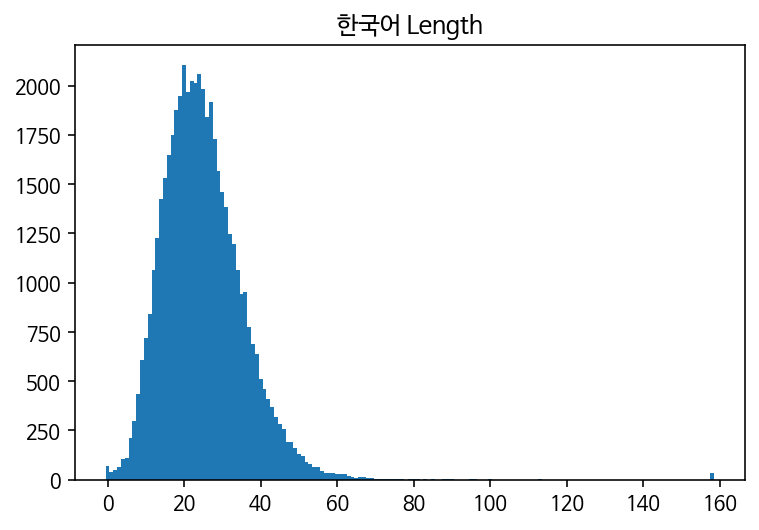

100%|██████████| 49639/49639 [00:00<00:00, 68815.78it/s]


영어 데이터셋의 최대 길이: 106
영어 데이터셋의 최소 길이: 2
영어 데이터셋의 평균 길이: 31
영어 데이터셋의 총 길이: 1577981
--------------------------------------------------------------------------------------------------------------------------------


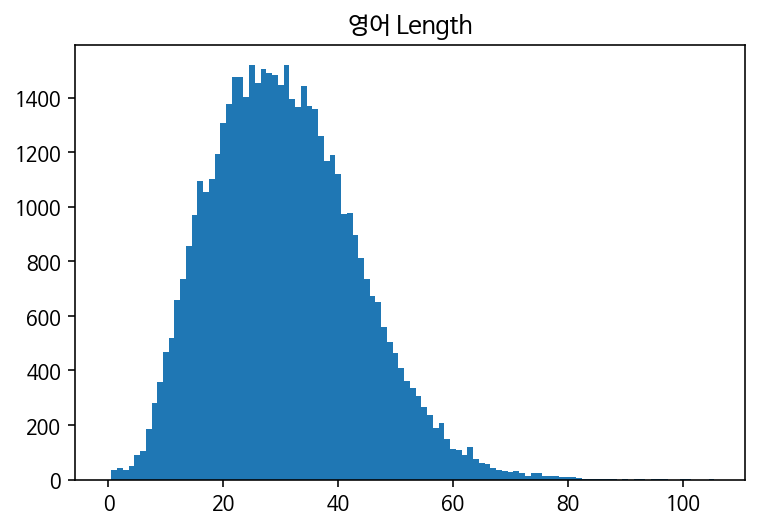

In [20]:
max_min_len(df['kor_corpus'], name='한국어')
max_min_len(df['eng_corpus'], name='영어')

In [21]:
df.head()

,kor_corpus,eng_corpus
0,"[1129, 363, 598, 550, 6, 1412, 1419, 10, 908, ...","[1, 311, 11, 1008, 6292, 14, 21, 52, 107, 95, ..."
1,"[167, 4200, 296, 3353, 24, 3763, 256, 21, 4200...","[1, 133, 9, 2943, 9, 356, 404, 317, 52, 9, 965..."
2,"[63, 908, 10, 158, 12340, 26, 4281, 469, 388, 4]","[1, 176, 84, 4182, 1543, 5336, 6, 39, 29, 71, ..."
3,"[4, 157, 42, 21, 8360, 3114, 4200, 296, 3353, ...","[1, 338, 5, 1139, 23, 96, 12917, 523, 6130, 5,..."
4,"[426, 1332, 10, 8811, 5884, 6, 9593, 13, 59, 9...","[1, 978, 106, 34, 1775, 8, 9, 4815, 36, 11, 85..."


In [22]:
df['kor_corpus'] = length_sentence(df['kor_corpus'], min_num = min_num, max_num = max_num, name='한국어')
df['eng_corpus'] = length_sentence(df['eng_corpus'], min_num = min_num, max_num = max_num, name='영어')

100%|██████████| 49639/49639 [00:16<00:00, 3077.70it/s]


In [23]:
df.isna().sum()

kor_corpus     9279
eng_corpus    11448
dtype: int64

In [24]:
df.dropna(inplace=True)

len(df)

33616

In [25]:
kor_corpus = list(df['kor_corpus'])
eng_corpus = list(df['eng_corpus'])

kor_corpus = tf.keras.preprocessing.sequence.pad_sequences(kor_corpus, padding='post', maxlen=max_num)
eng_corpus = tf.keras.preprocessing.sequence.pad_sequences(eng_corpus, padding='post', maxlen=max_num)

---
## 3. 모델 구성하기

In [66]:
# 하이퍼 파라미터

vocab_size = 15000
units = 256
BATCH_SIZE = 16
EPOCHS = 10

pos_len = max_num
num_heads = 4
num_layers = 2
d_model = 1024
drop_rate = 0.2
d_ff = d_model*4
warmup_steps = 4000

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "오늘 오전 태평양 인근에서 비행기 한대가 추락했다."
]

In [67]:
def hyper_parameter():
    print('Hyper Parameters: ','\n', '===='*26, '\n',
          
          'Vocab Size: ', vocab_size, '\n'
          'Units: ', units, '\n',
          'Batch Size: ', BATCH_SIZE, '\n',
          'Epochs: ', EPOCHS, '\n', '===='*26, '\n','\n'
          
          'Transformer Layer Parameters', '\n', '===='*26, '\n',
          
          'Num Heads: ', num_heads,'\n',
          'Num Layers: ', num_layers, '\n',
          'Positional length: ', pos_len, '\n',
          'D_model: ', d_model, '\n',
          'dropout rate: ', drop_rate, '\n',
          'd_ff: ', d_ff, '\n',
          'Warmup Steps: ', warmup_steps, '\n', '====' *26
           )

In [68]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [69]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # tf.cast: 그냥 새로운 dtype으로 바꿔주는 함수
                                                     # 거즘 원핫인코딩 같은 방식인듯 하다
                                                     # tf.math.equal(x,y) : (x,y) 끼리 index가 일치하는 곳만 bool로 return
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0) # np.cumsum : 행렬의 누적합 계산
                                                      # np.eye(행, 열, dtype=float) : 단위행렬 만들어주는 함수
                                                      # 대각선에 1이 있고 다른 곳에 0이 있는 2차원 배열을 반환합니다.
                                                      # 이것을 단위행렬이라고 한다. (대각으로 1로 구성되고 나머지는 0으로 구성된 행렬)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [70]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position/np.power(10000, int(i) / d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [71]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        
        """
        Scaled QK 값 구하기
        """

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  
            
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
          
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [72]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model) # Dense층은 차원 맵핑용

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [73]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x # skip-connection
        out = self.norm_1(x) # 어텐션 레이어에 들어가기 전 Normalization이 이루어짐. 그림에 명시되지 않음.
        out, enc_attn = self.enc_self_attn(out, out, out, mask) # Self-attention
        out = self.dropout(out) # Normalization
        out += residual # add
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out # skip-connection
        out = self.norm_2(out) # 다시 한번 명시되진 않았지만 layer에 들어가기 전 Normalizaion을 해줌.
        out = self.ffn(out) # ffn layer에 입력
        out = self.dropout(out) # Normalizaion
        out += residual # add
        
        return out, enc_attn

In [74]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [75]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [76]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [77]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.5,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """        
        
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [79]:
learning_rate = LearningRateScheduler(d_model, warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [80]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

---
## 4. 모델 학습 및 결과 확인

In [78]:
transformer = Transformer(num_layers,
                    d_model,
                    num_heads,
                    d_ff,
                    vocab_size,
                    vocab_size,
                    pos_len,
                    dropout = drop_rate)

In [81]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [82]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = clear_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=max_num,
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(eng_corpus.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [83]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('입력 문장: %s' % (sentence))
    print('출력 문장: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
        
    print('\n')        

In [84]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

Hyper Parameters:  
 Vocab Size:  15000 
Units:  256 
 Batch Size:  16 
 Epochs:  10 
 
Transformer Layer Parameters 
 Num Heads:  4 
 Num Layers:  2 
 Positional length:  45 
 D_model:  1024 
 dropout rate:  0.2 
 d_ff:  4096 
 Warmup Steps:  4000 


  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: the president of the clinton of president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: the city of the city of the city of the city , said the city of the city of the city of the city of the city of the city .


입력 문장: 커피는 필요 없다.
출력 문장: theyre just amid the production . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the dead reported amid a tropical storm . s . magnitude . magnitude .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: the man was a man who was a man who was a footage .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: in his final , obama spent the final in the final in the final in the final in the final in the past , obama in the final in the past .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: the city of the national hurricane center in the city of each other , the mostly in the national city of each others in the city of each other in the city .


입력 문장: 커피는 필요 없다.
출력 문장: not enough to pay the need for us to be used in the using .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the death toll killed six victims in the death toll in the death .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: today , the first plane crashed into the house in the th minute crash in the plane crashed into the plane crash .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: obama obama , obama , obama , obama , obama , obama , obama , obama , obama , obama , obama , obama , obama , obama , obama , obama , obama .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: the organizations are being prepared to begin in san francisco .


입력 문장: 커피는 필요 없다.
출력 문장: coffee said it was not seen as well , but not because i cannot afford to do not have never lost out .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the death toll from the death toll from the death toll killed people and wounded people wounded people wounded people wounded five people were wounded .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: the plane landed at a . m . , just arrived at the pacific ocean , a man was shot in a plane crash in a plane crashed into a plane crashed into a plane crashed area .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: obama is president , obama is president , obama is president , obama is president .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: the number of people have been shelter in the number of areas where the town of the state of emergency .


입력 문장: 커피는 필요 없다.
출력 문장: in the kids are not a not know the kid .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the record of the deadliest attack wednesday morning , the deadliest attack killed people and , the deadliest attack sunday morning .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: a morning america crashed nearly a plane crashed nearly a plane around the world , a u . s . aircraft , which more than two decades ago .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: obama is the voters , obama is president of presidents president , obama is president .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: the citizens city of towns and the city of towns where heavy snowfall is in the city of towns where heavy snowfall .


입력 문장: 커피는 필요 없다.
출력 문장: it needs for no . it need for nob for nob . . .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the death toll died monday at least seven people died when the u . s . killed at least seven people .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: the arrived in washington , a plane hit the house , then an hour , then an area near the city of washington , then an area , an fbi agent said .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: obama is a president aiming for obama is a president . . . .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: one day is in the worlds main event .


입력 문장: 커피는 필요 없다.
출력 문장: no need for no . for words , no need for coffee .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the record of , which came as u . s . member of the dead were killed , and six of the seven wounded saturday , entered the record of .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: the just came from around the age when one day from the plane came from the plane came from around the world .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: that is a greater attention .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: the move free upon it upon from the towns where the towns into the towns and the city is free to one of the most towns and the mothers free .


입력 문장: 커피는 필요 없다.
출력 문장: no need or no coffee . no coffee . . . . no coffee . .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the seven entered the there monday with the wednesday left seven people dead and seven people .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: as a . m . , the plane crashed into the area , the suburban county , the flight , the just before the plane crash .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: obama is a questioning president for obama . . . . . . . . obama . . . . . . . . . . . . . . . . . . . . . . . . . . . .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: the city is now where the family have lost two to three in the city of san f urban parts of the city have already poor urban parts .


입력 문장: 커피는 필요 없다.
출력 문장: no need for no . know not . . . kid wont need .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: on monday , seven people were killed and monday with seven of the seven were monday .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: an afternoon just disappeared from washington airport under house until his just one go crashed , around a . m .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: is a president with is . . president bush . . . . obama . is a president .


입력 문장: 시민들은 도시 속에 산다.
출력 문장: in the city of towns , where the three mountain town of another city grow into the city of events .


입력 문장: 커피는 필요 없다.
출력 문장: no further or know not top . . . . . no coffee . its .nt know why .


입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: about . magnitude earthquake wednesday killed six people thursday as many as were wounded during its seven monday .


입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: an morning america stepped into a airport that exploded near a . m .




  0%|          | 0/2101 [00:00<?, ?it/s]

입력 문장: 오바마는 대통령이다.
출력 문장: obama is president . . . . president . . . . is a obama . president . . . . . president . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


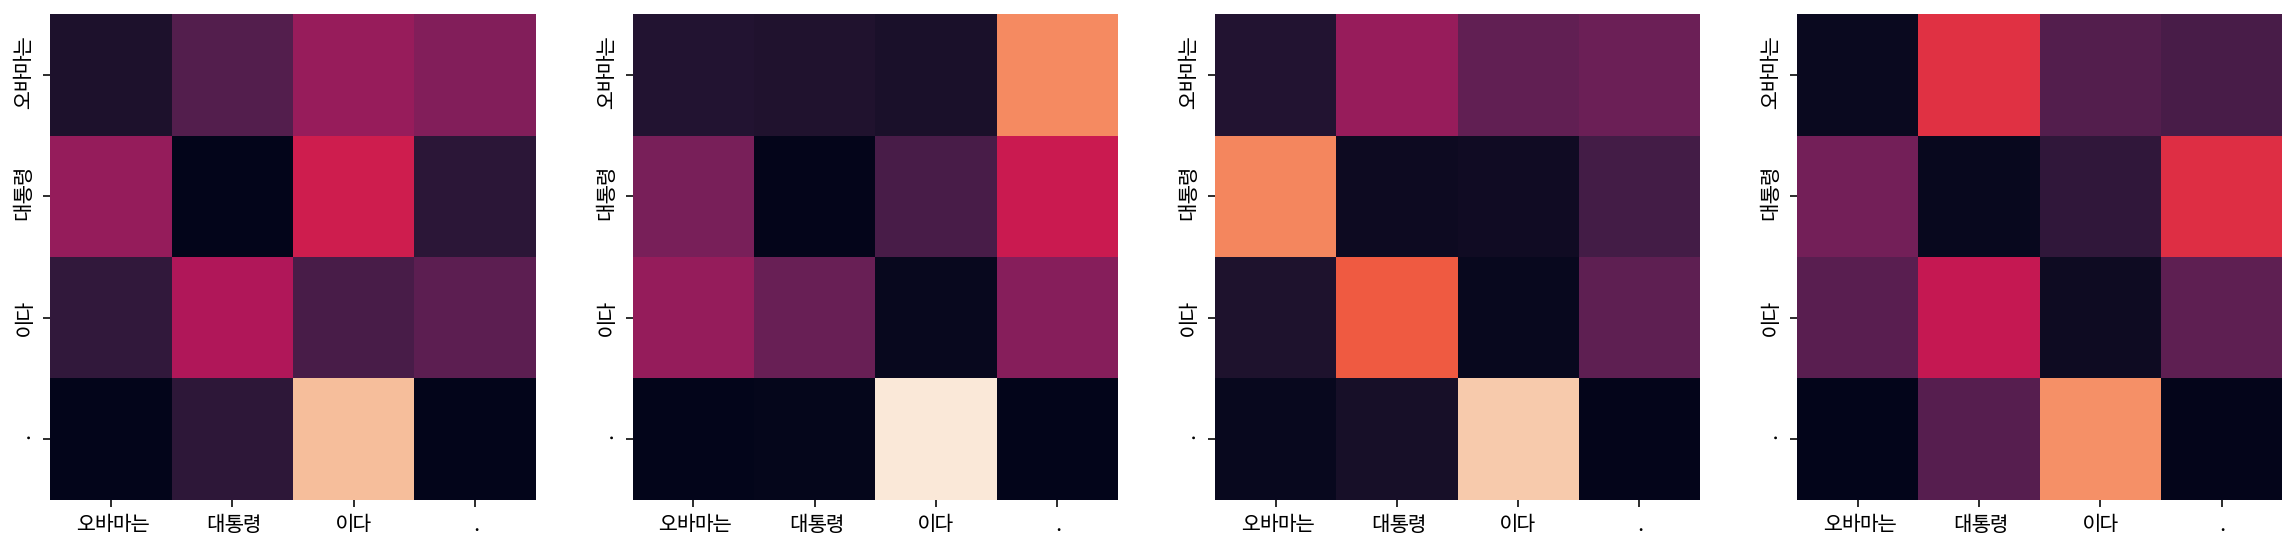

Encoder Layer 2


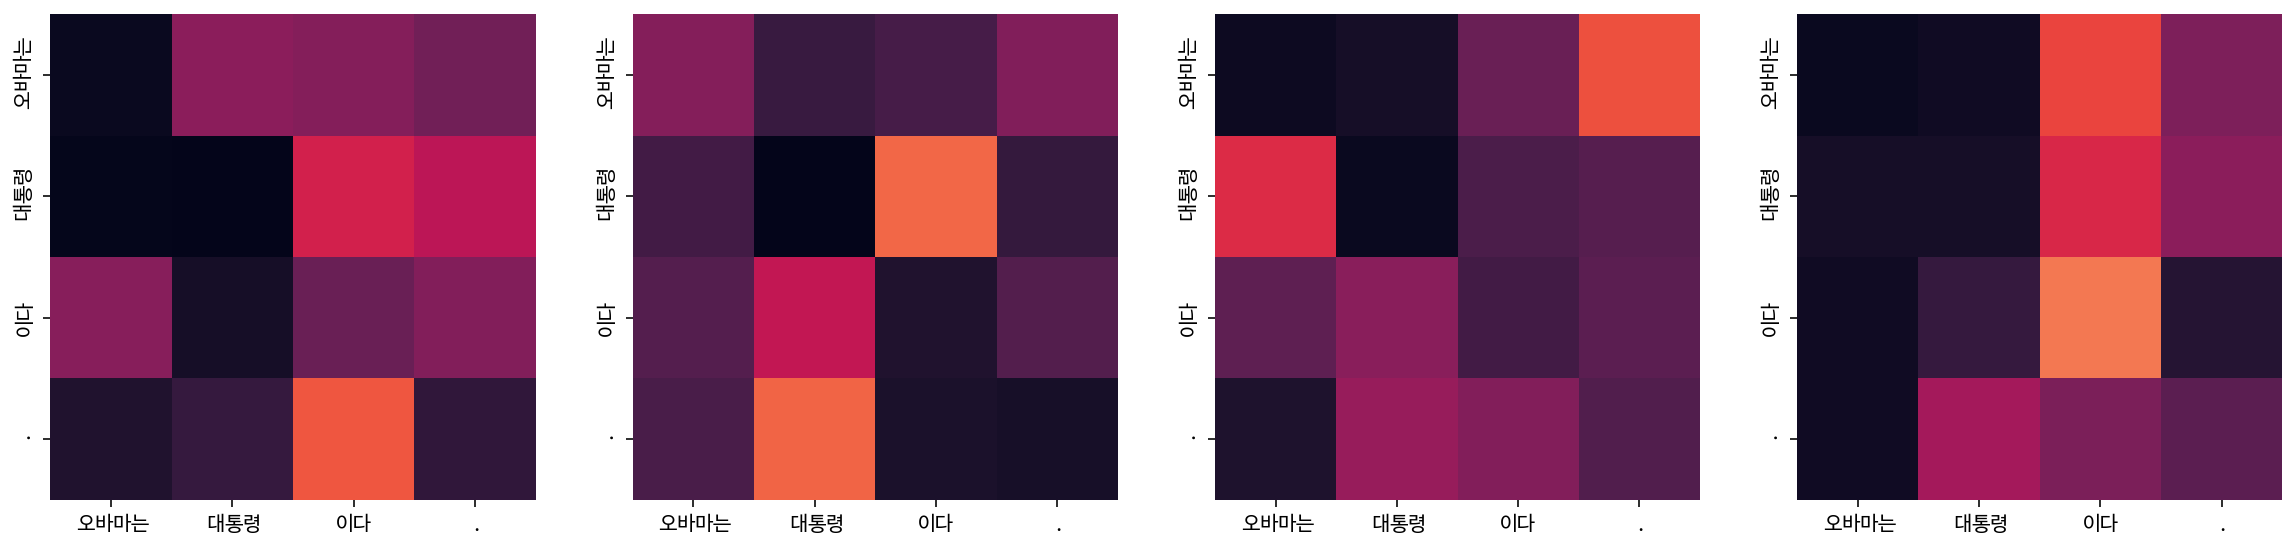

Decoder Self Layer 1


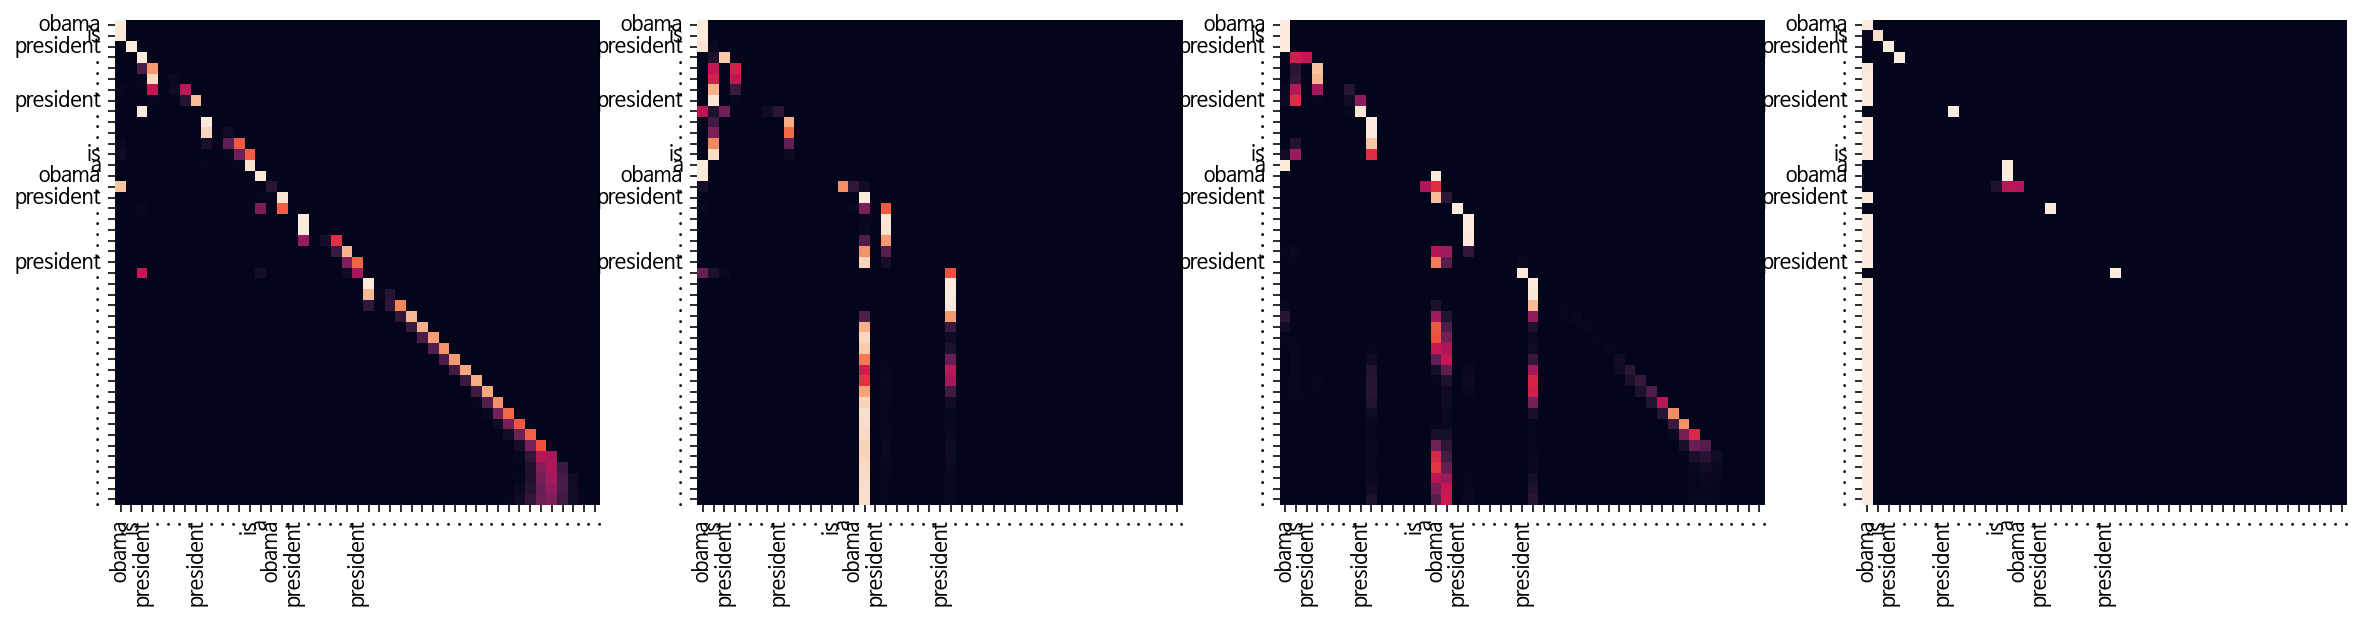

Decoder Src Layer 1


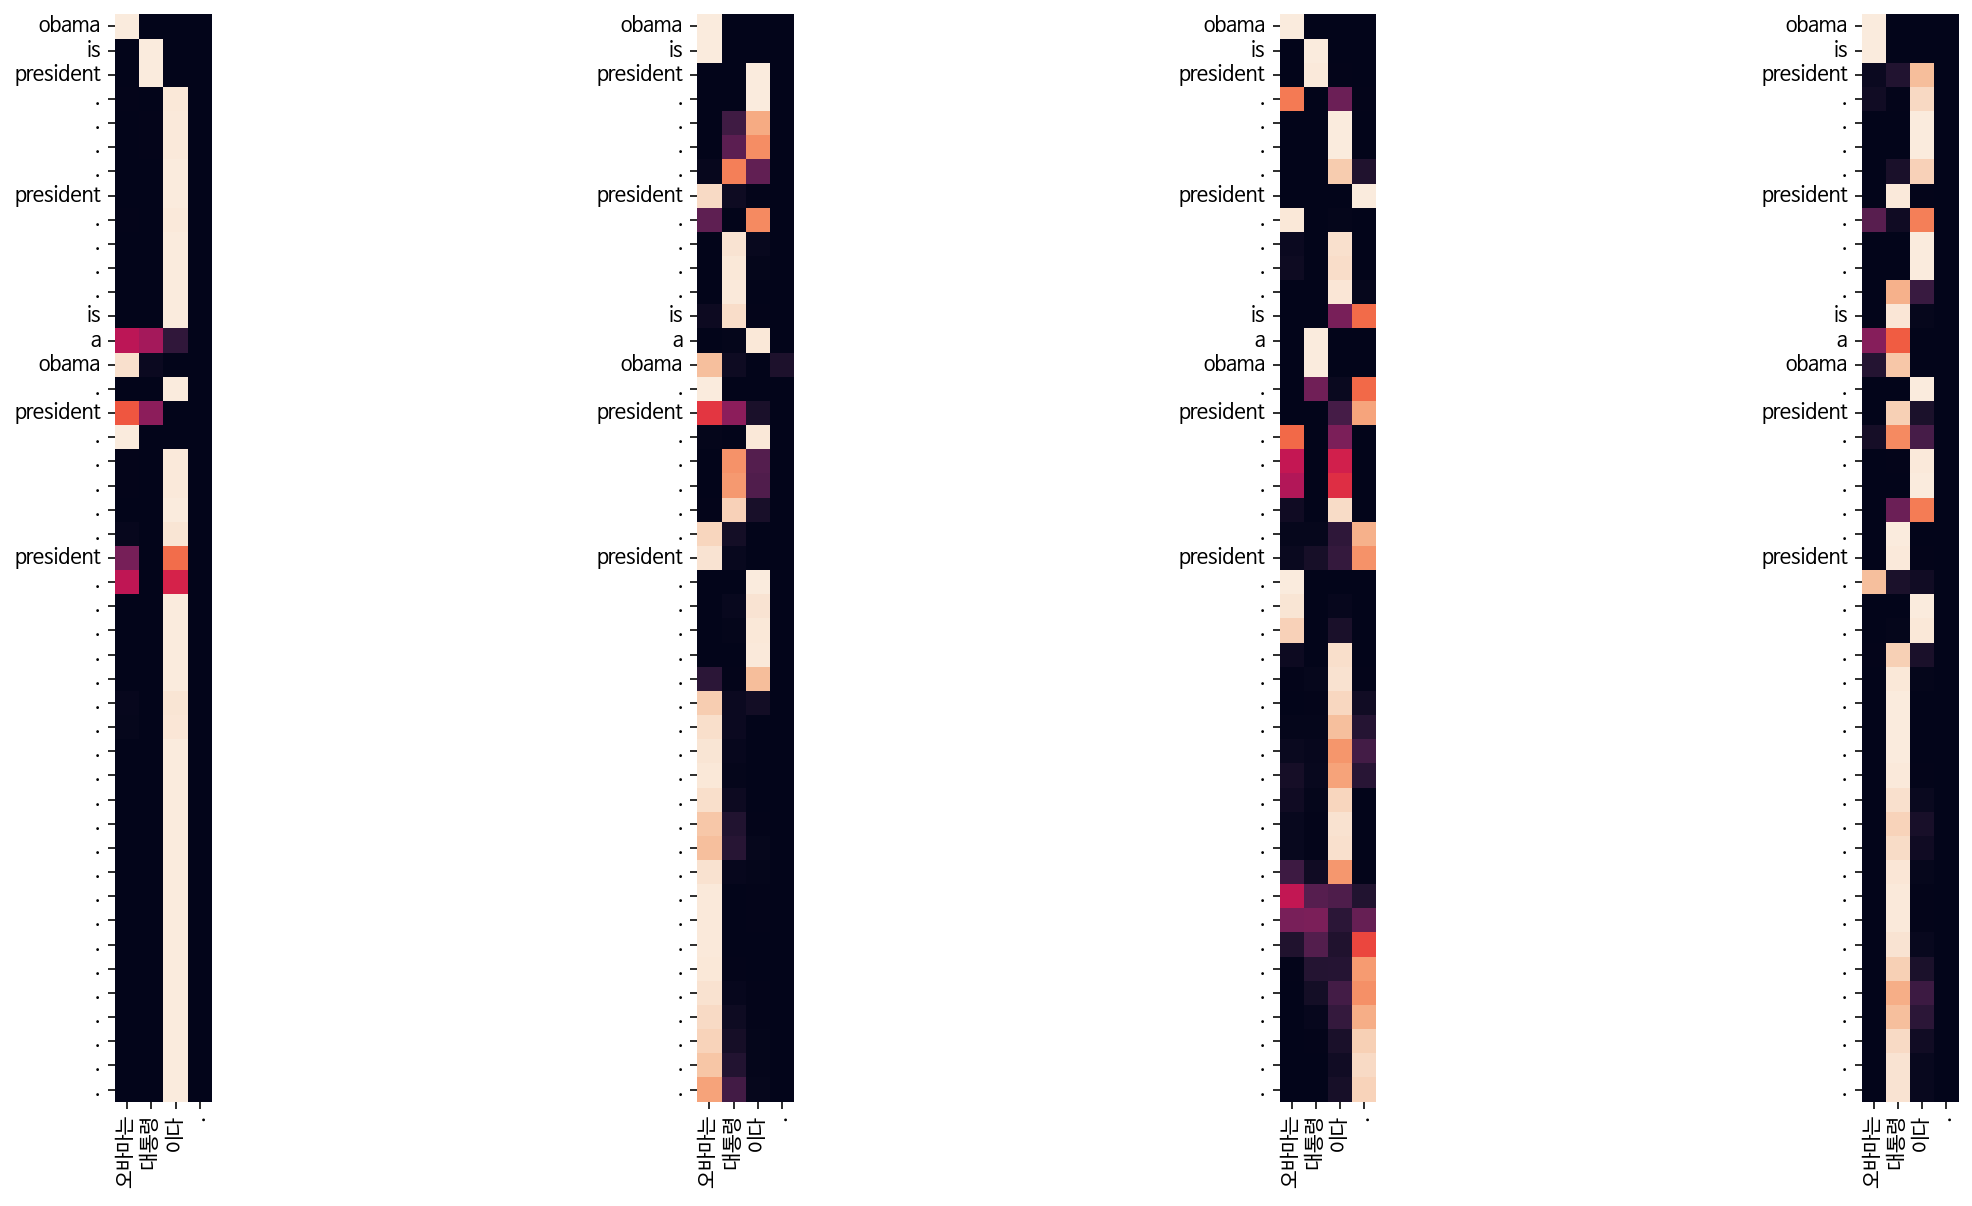

Decoder Self Layer 2


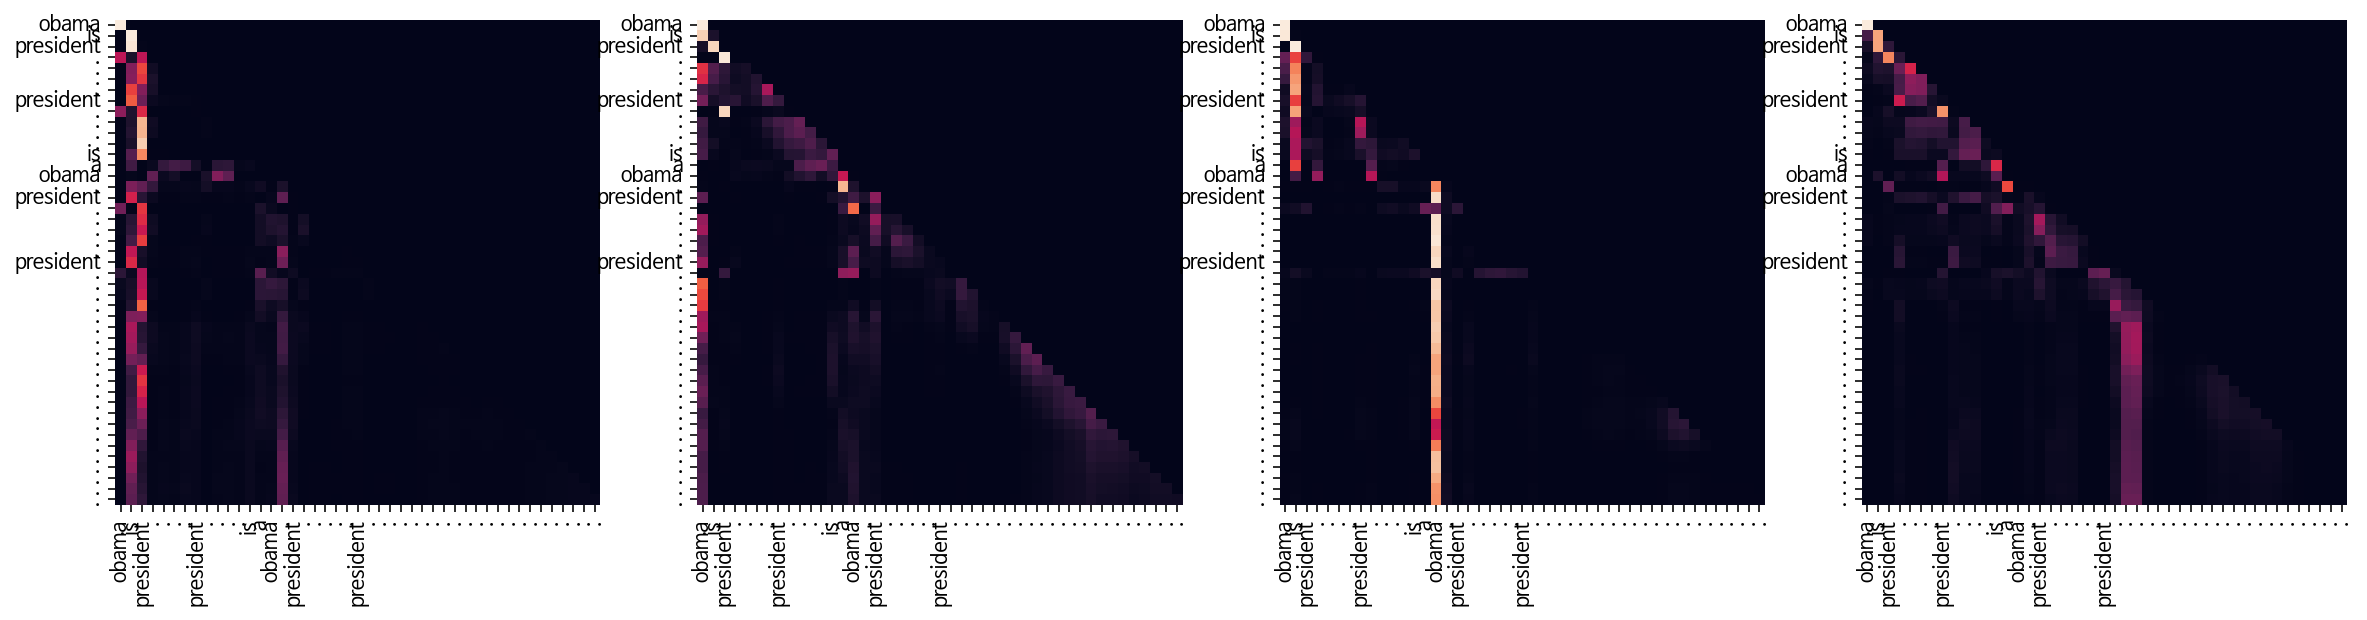

Decoder Src Layer 2


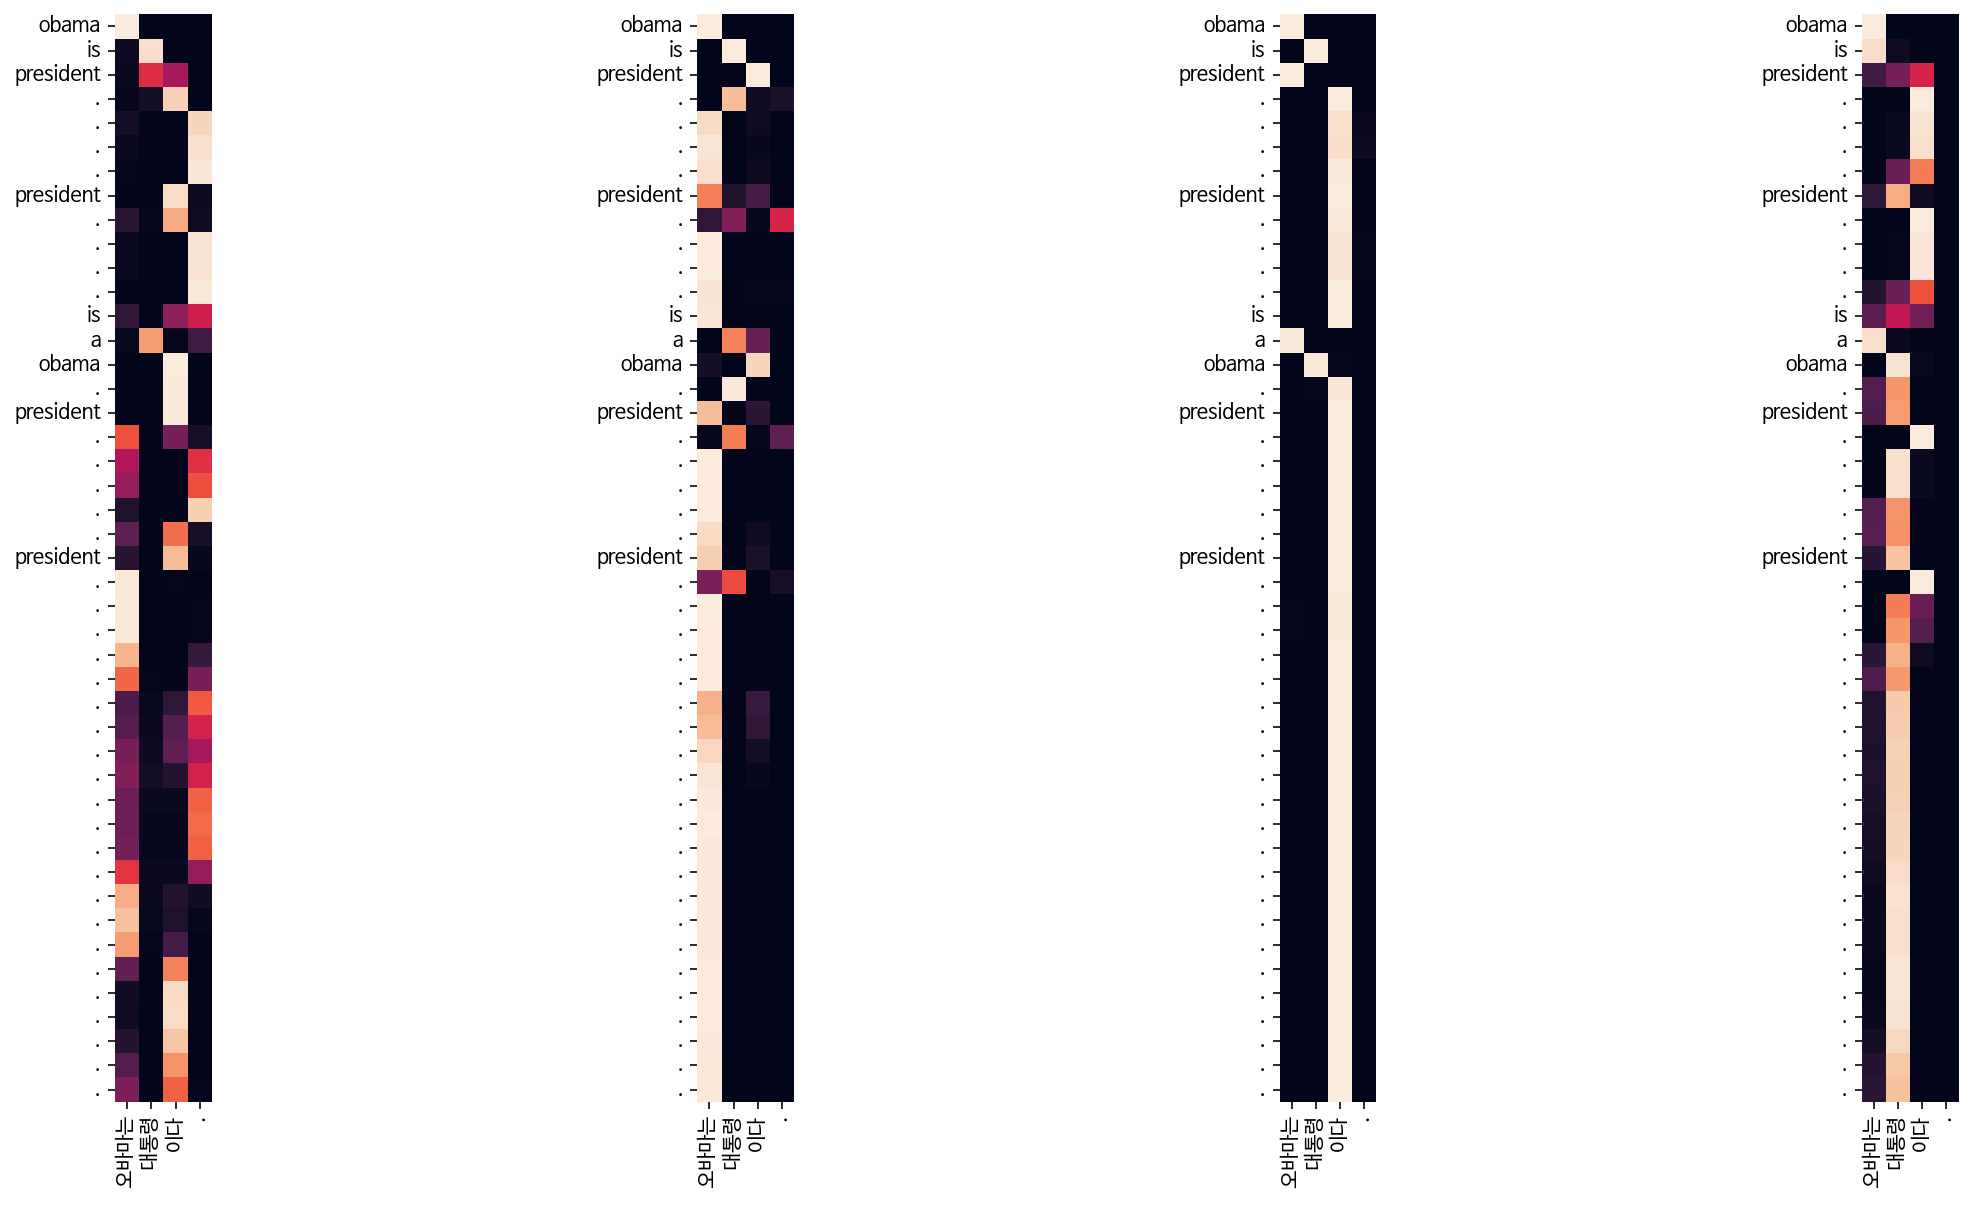



입력 문장: 시민들은 도시 속에 산다.
출력 문장: the beach is in town of on every day and a where parts of the town in far , the city where parts of the town in control of the town .
Encoder Layer 1


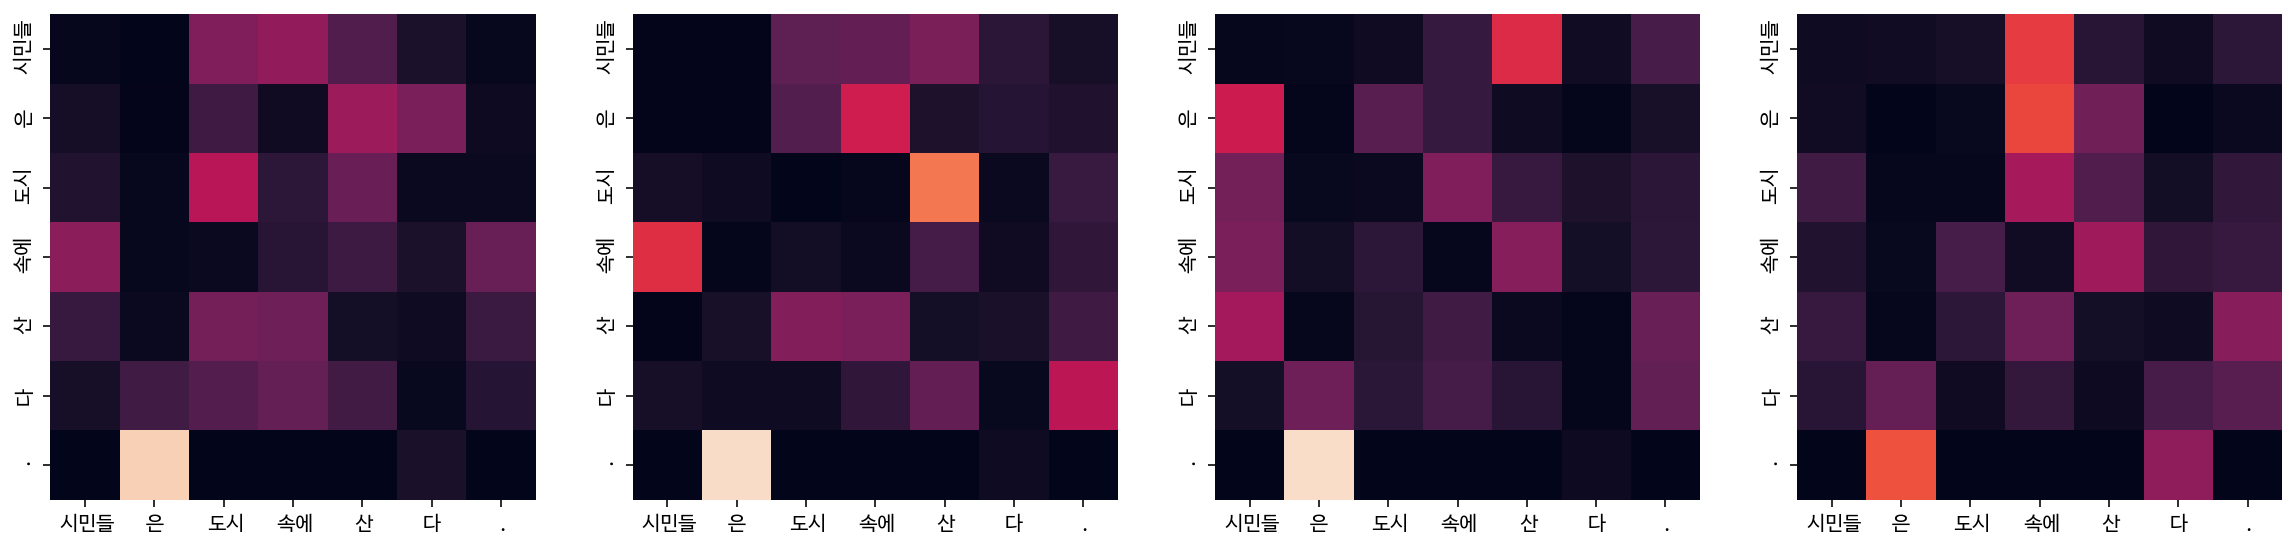

Encoder Layer 2


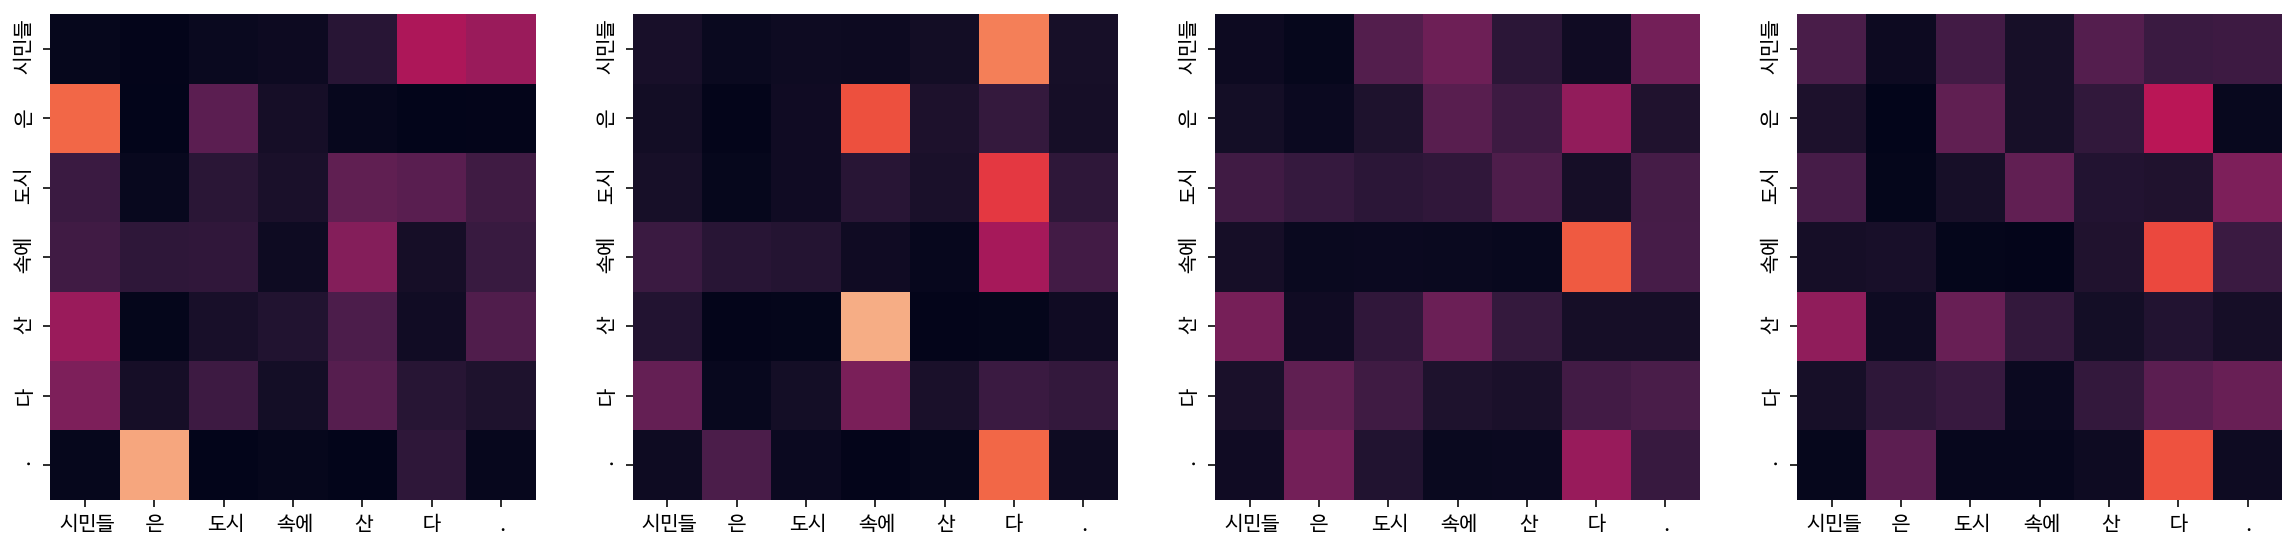

Decoder Self Layer 1


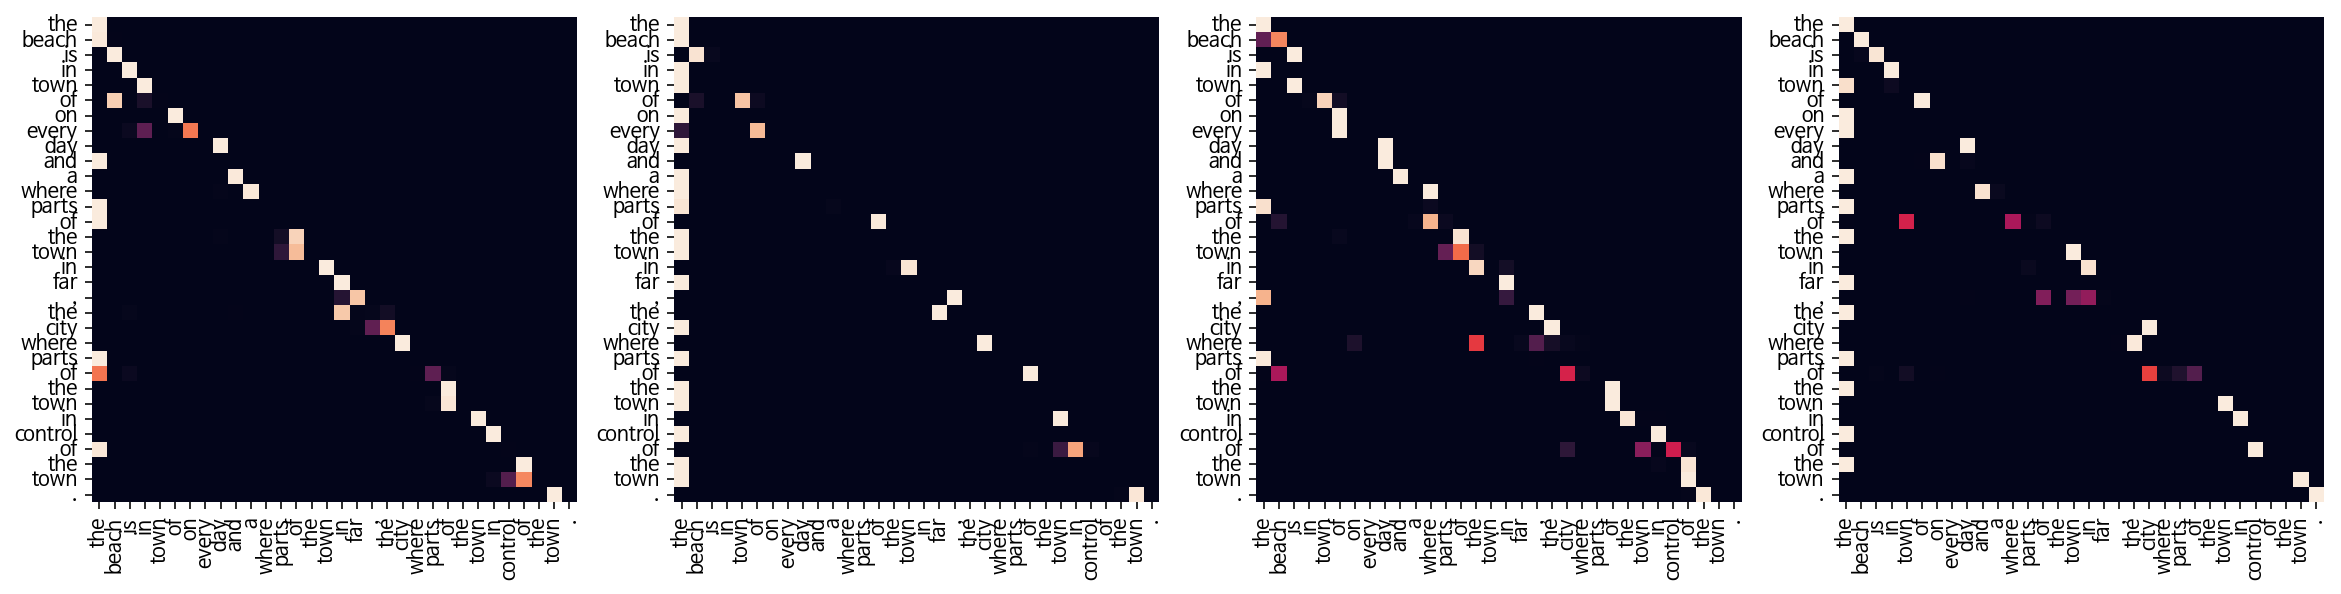

Decoder Src Layer 1


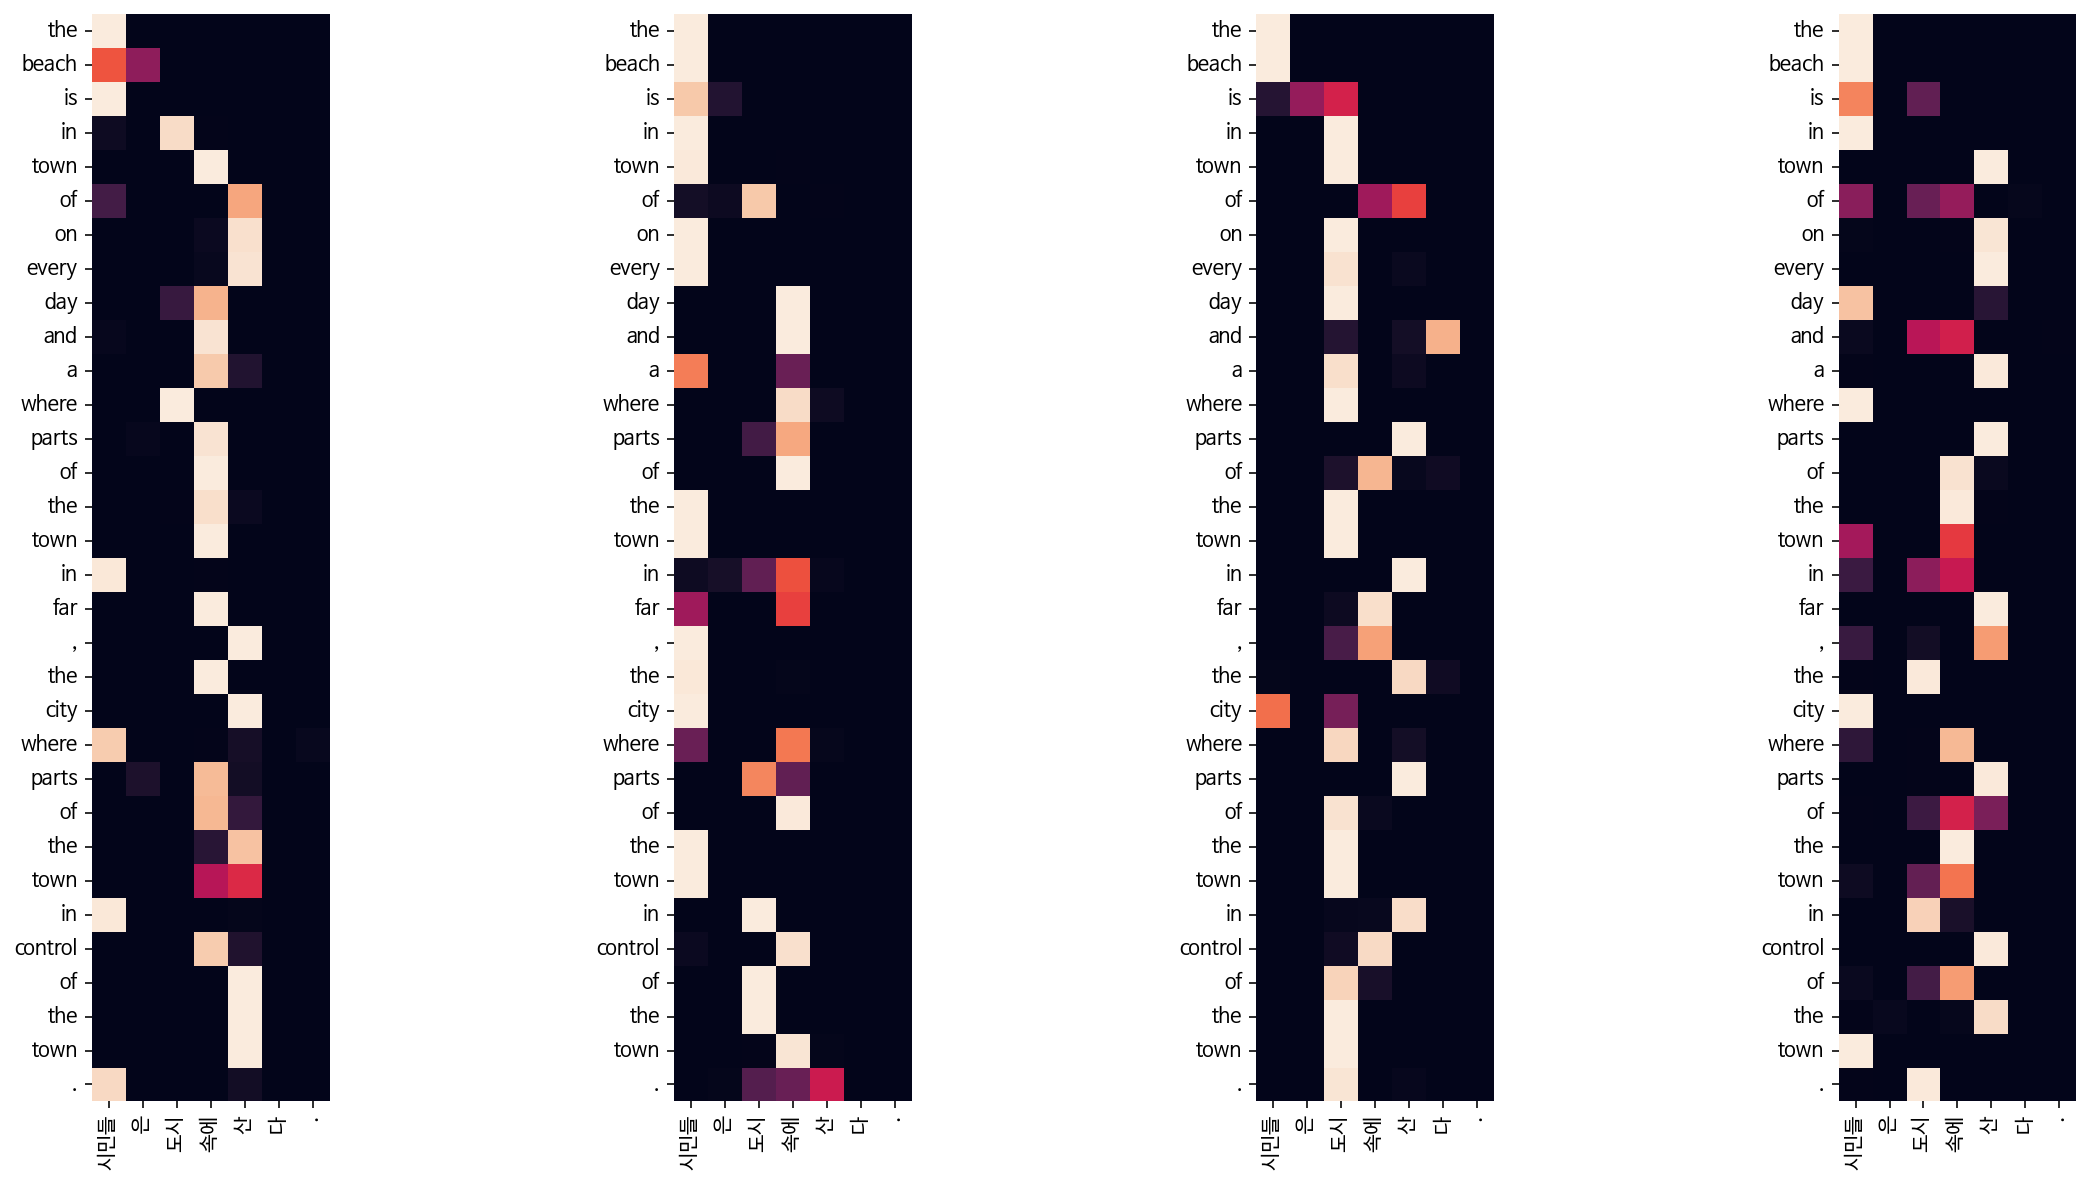

Decoder Self Layer 2


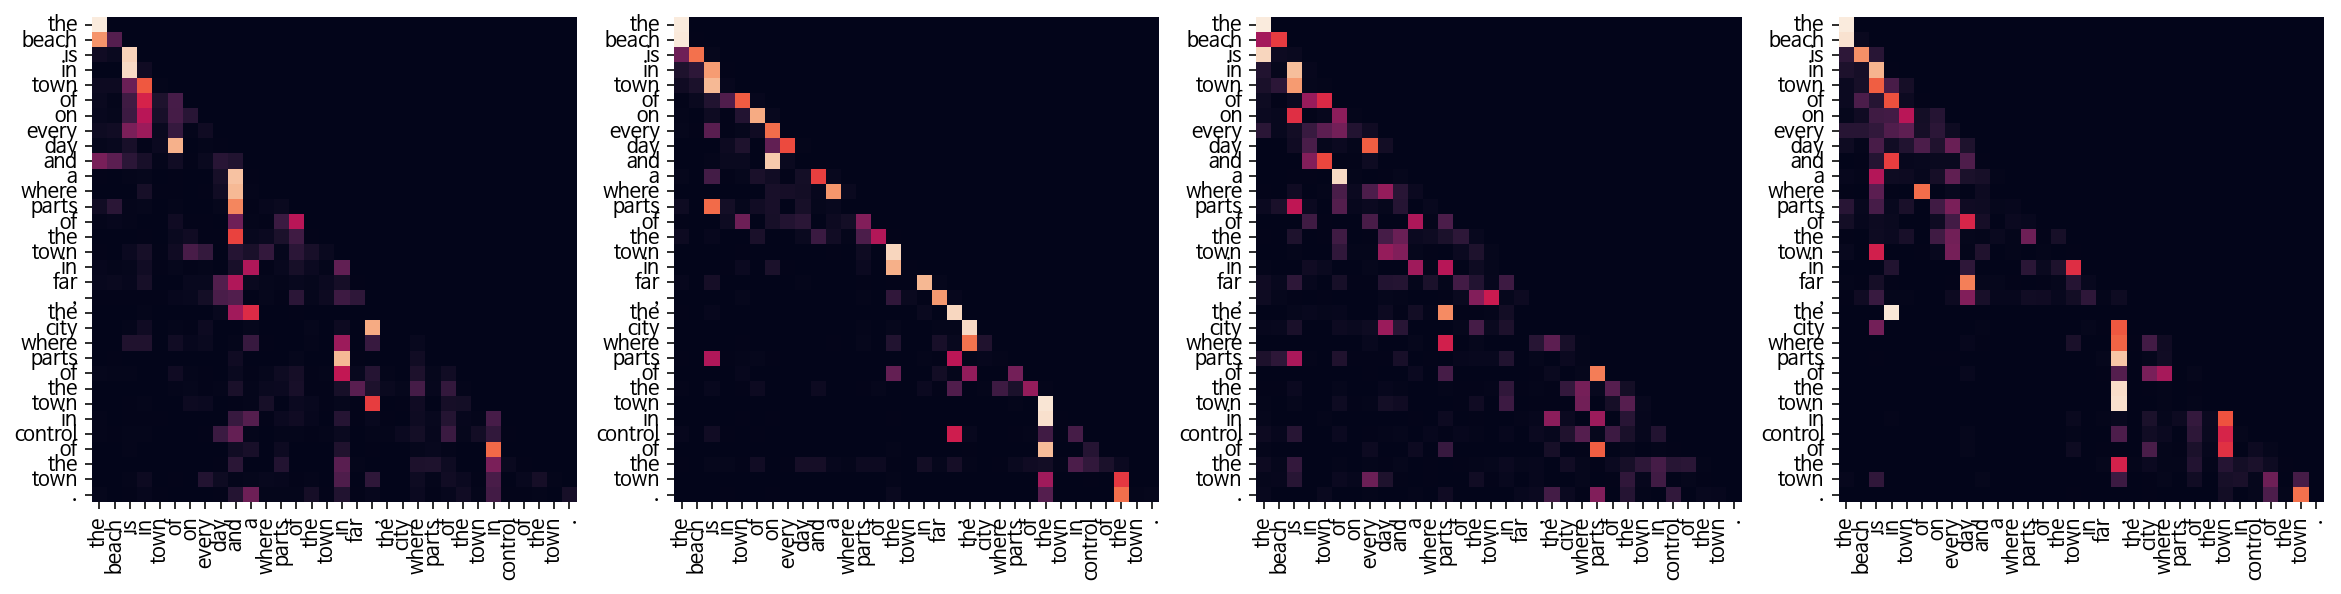

Decoder Src Layer 2


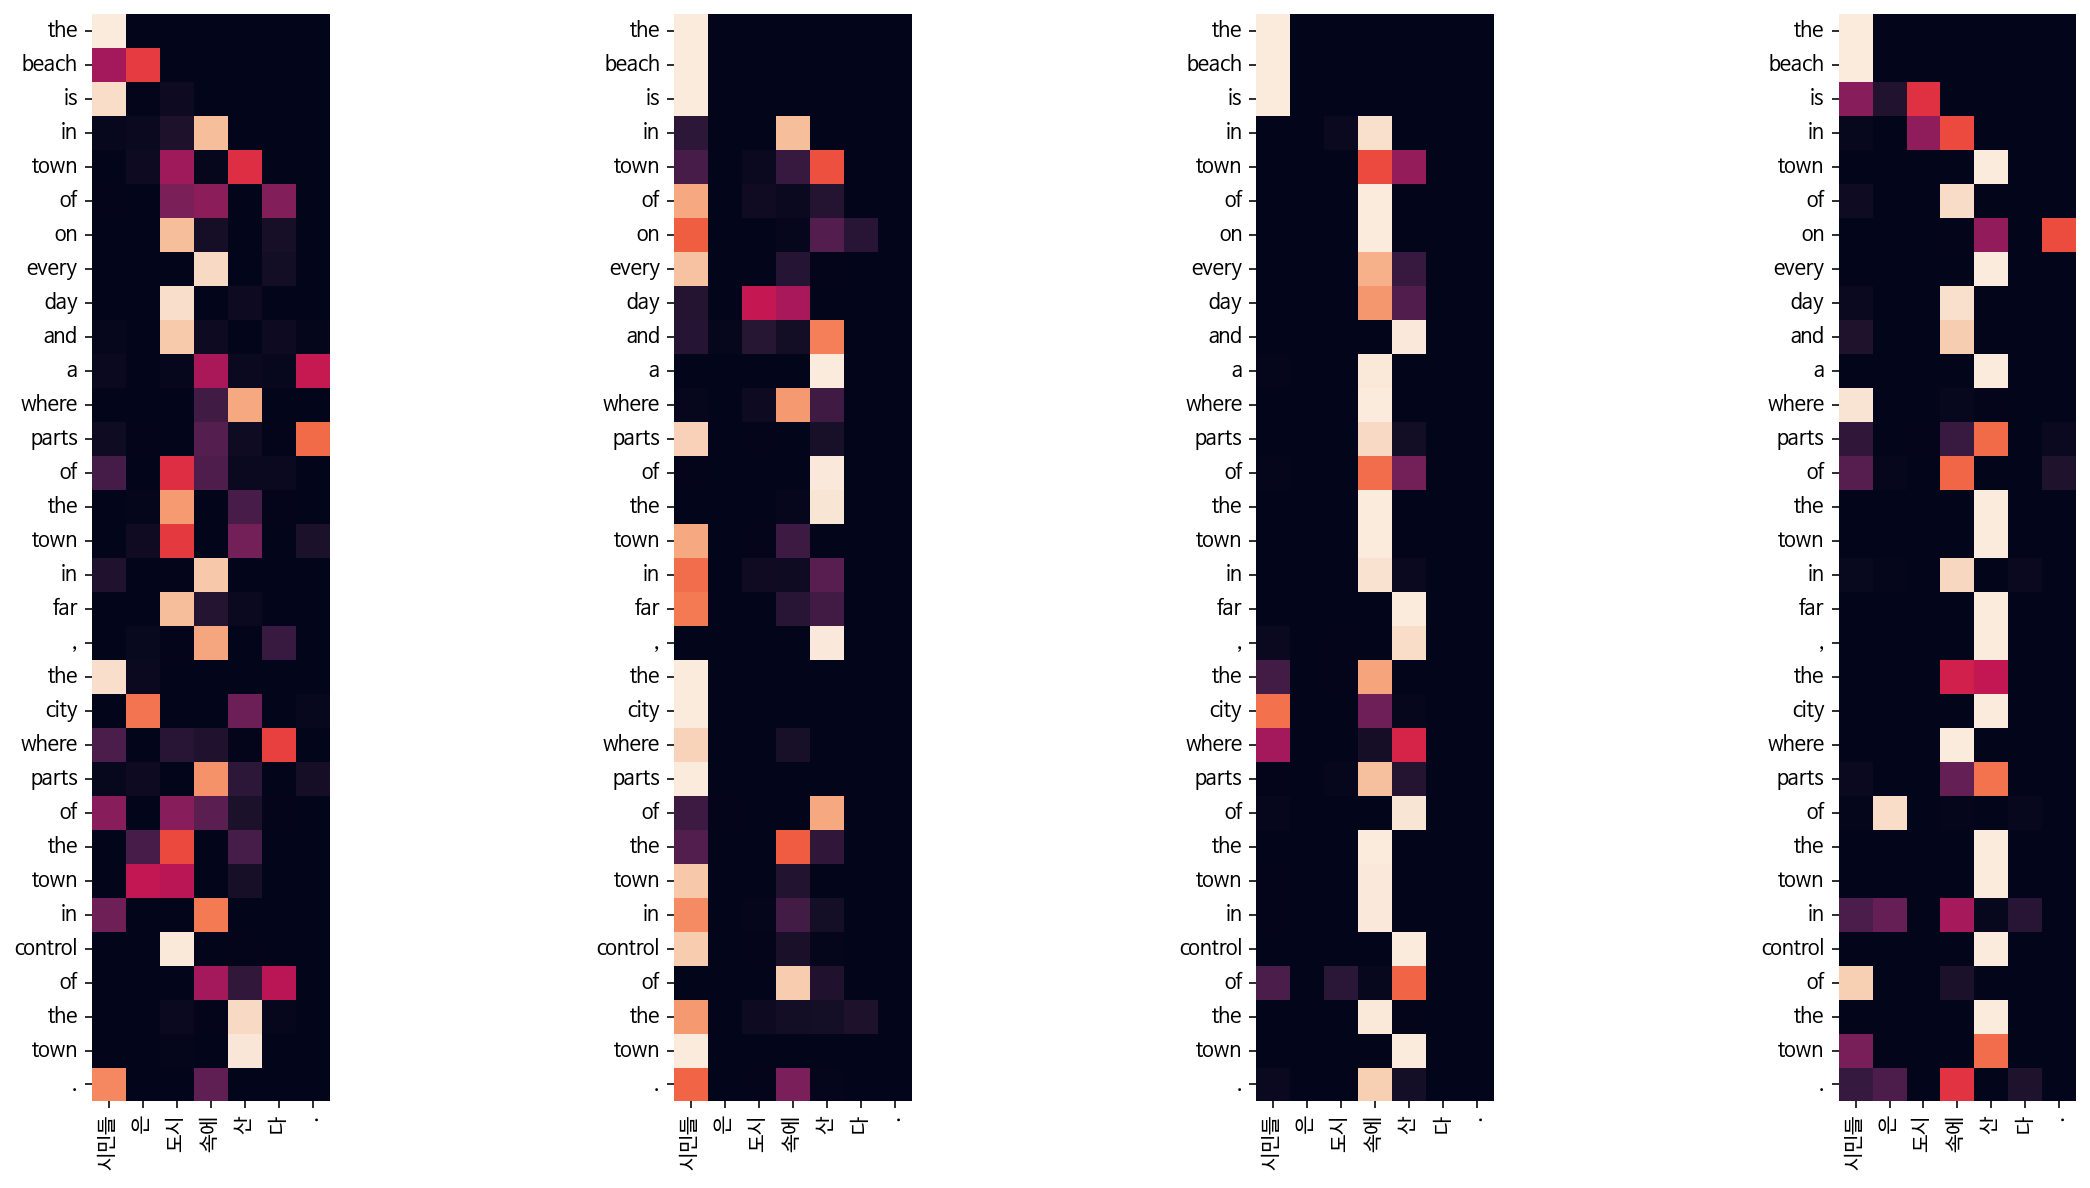



입력 문장: 커피는 필요 없다.
출력 문장: its not getting . percent .
Encoder Layer 1


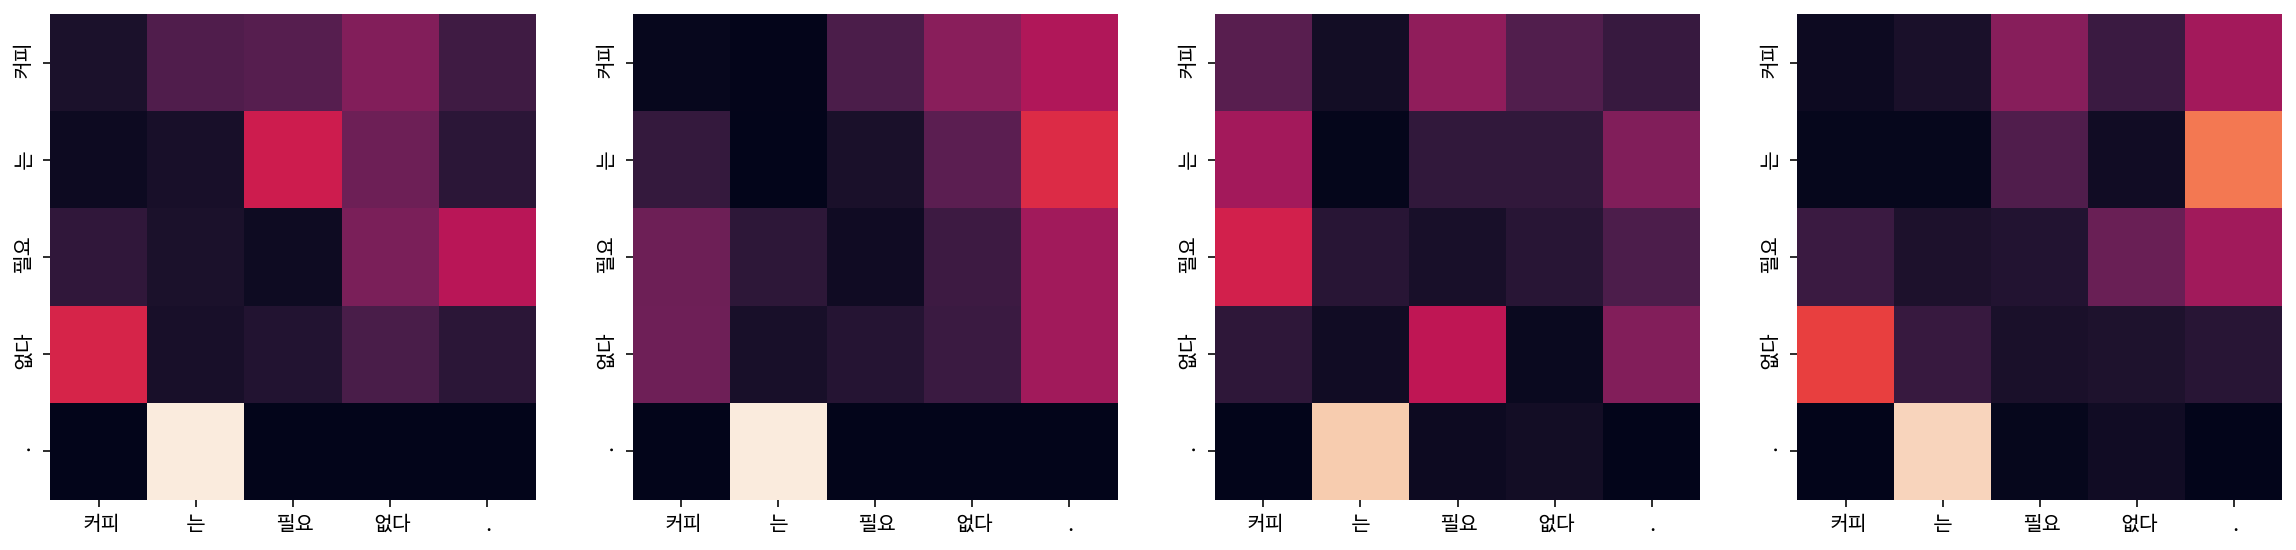

Encoder Layer 2


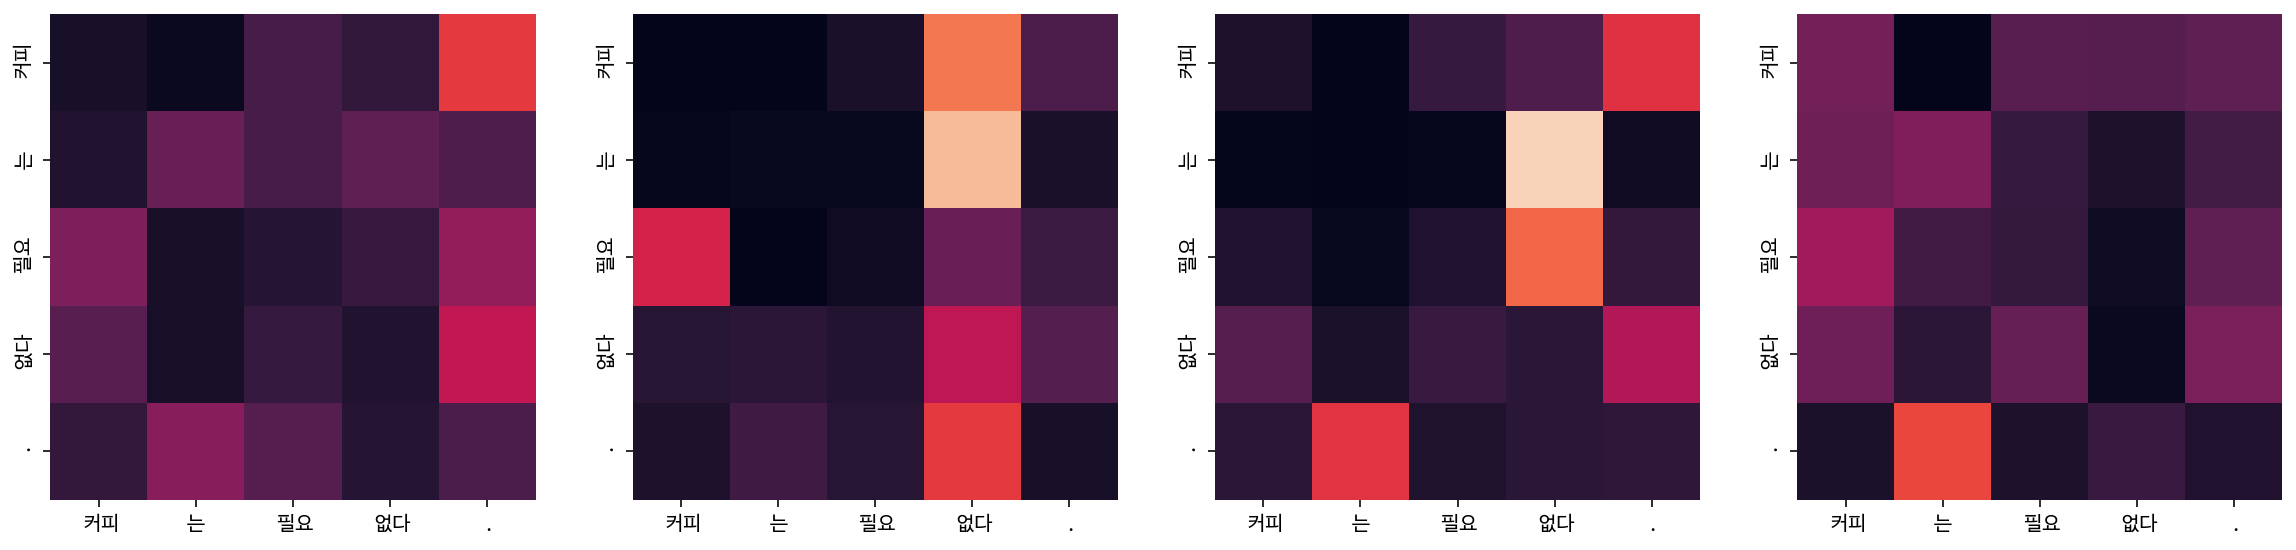

Decoder Self Layer 1


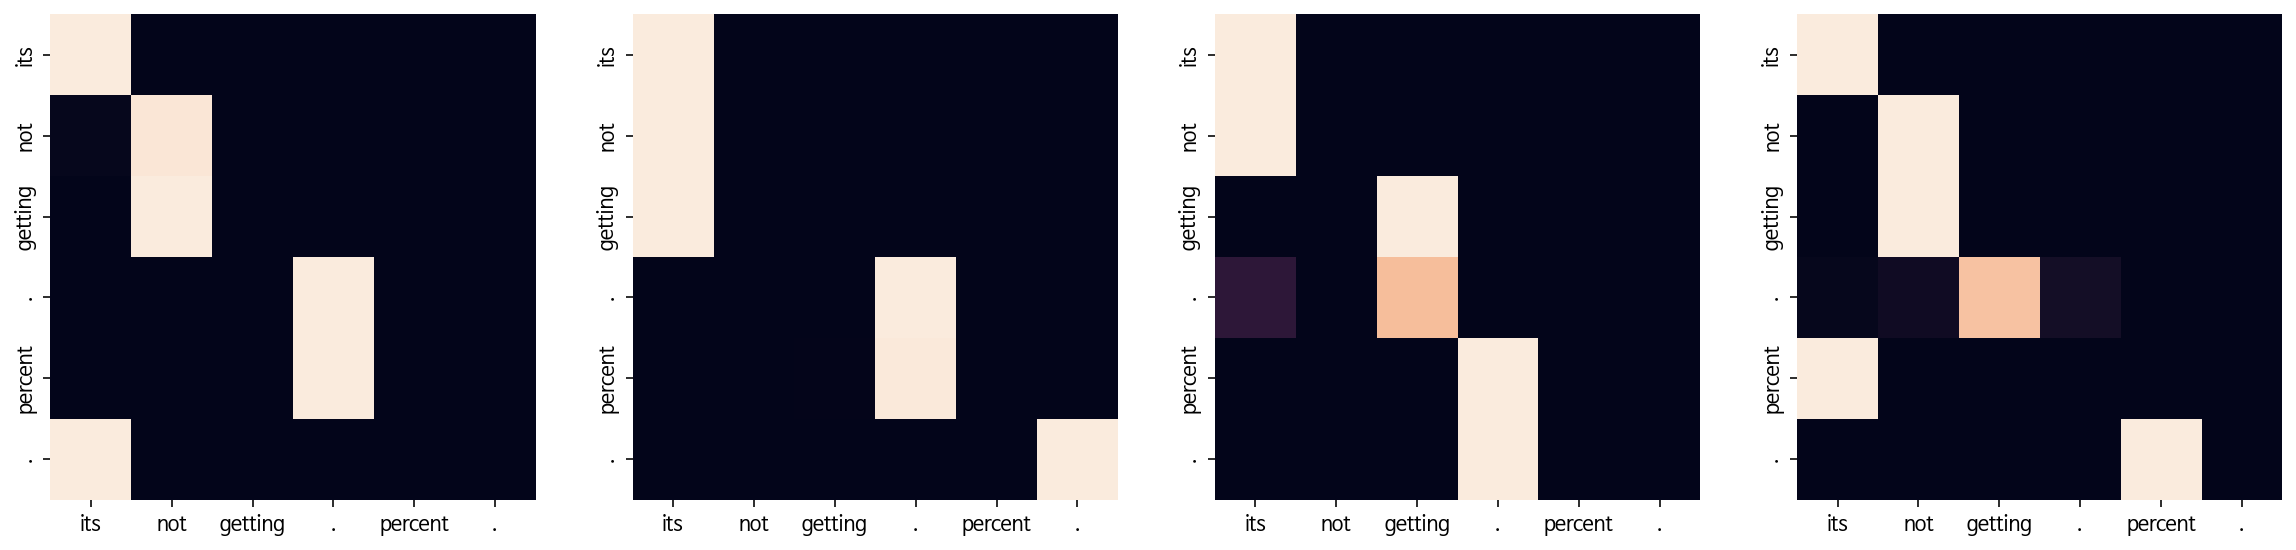

Decoder Src Layer 1


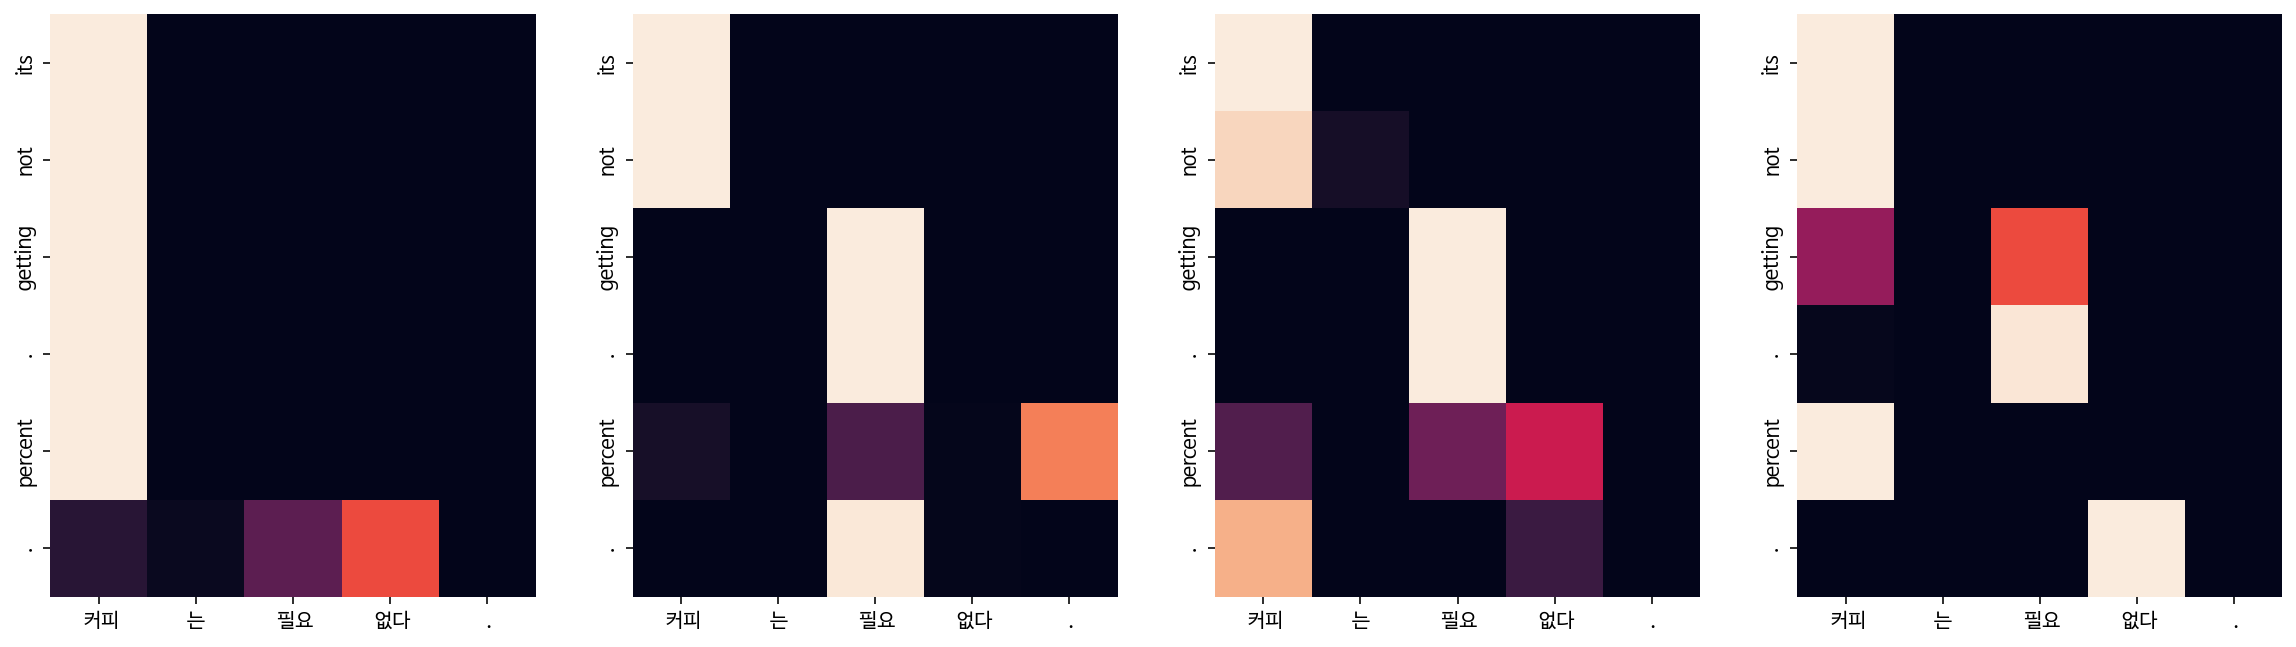

Decoder Self Layer 2


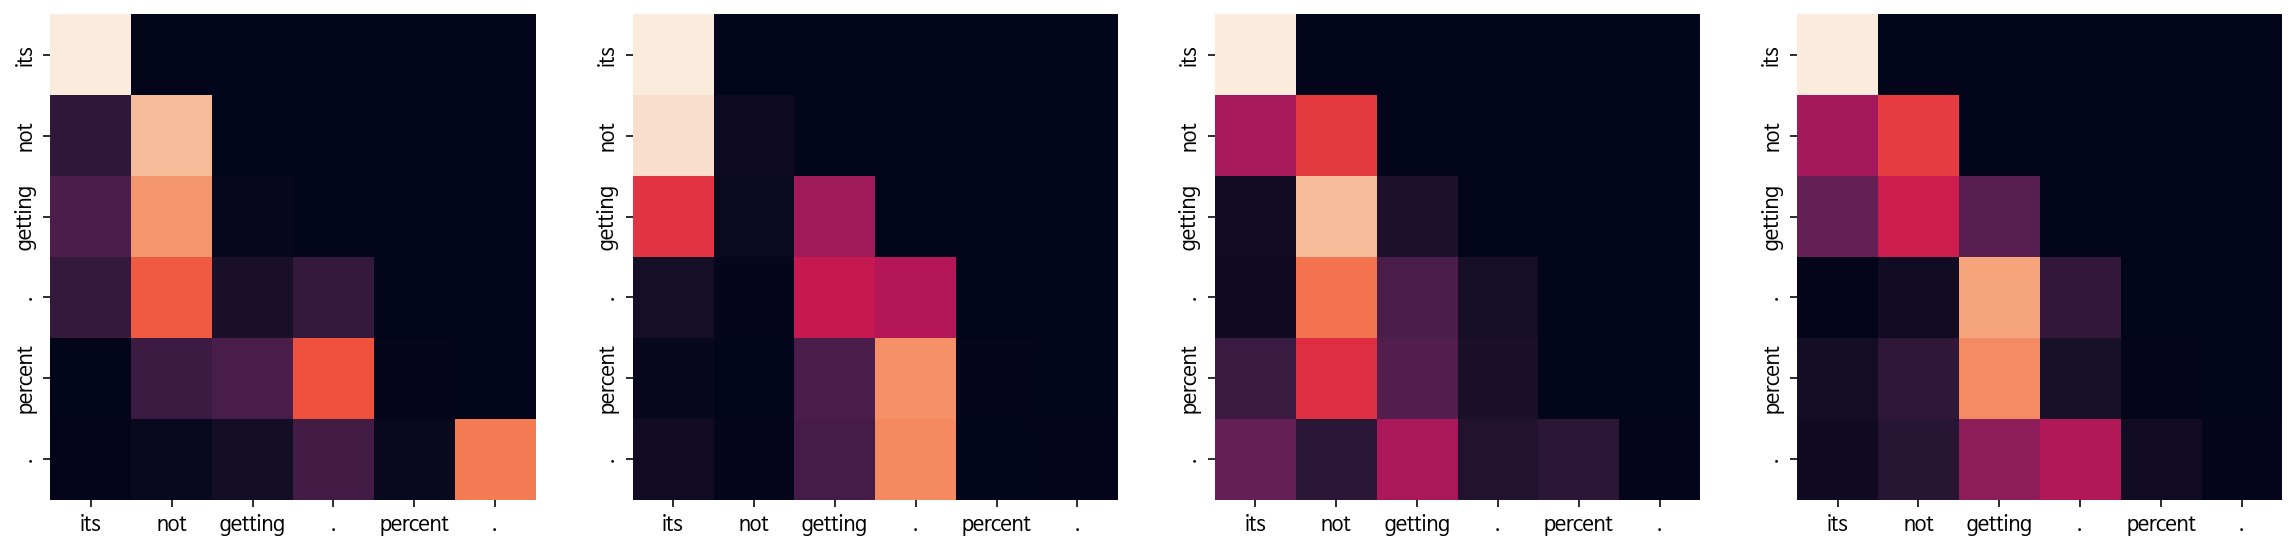

Decoder Src Layer 2


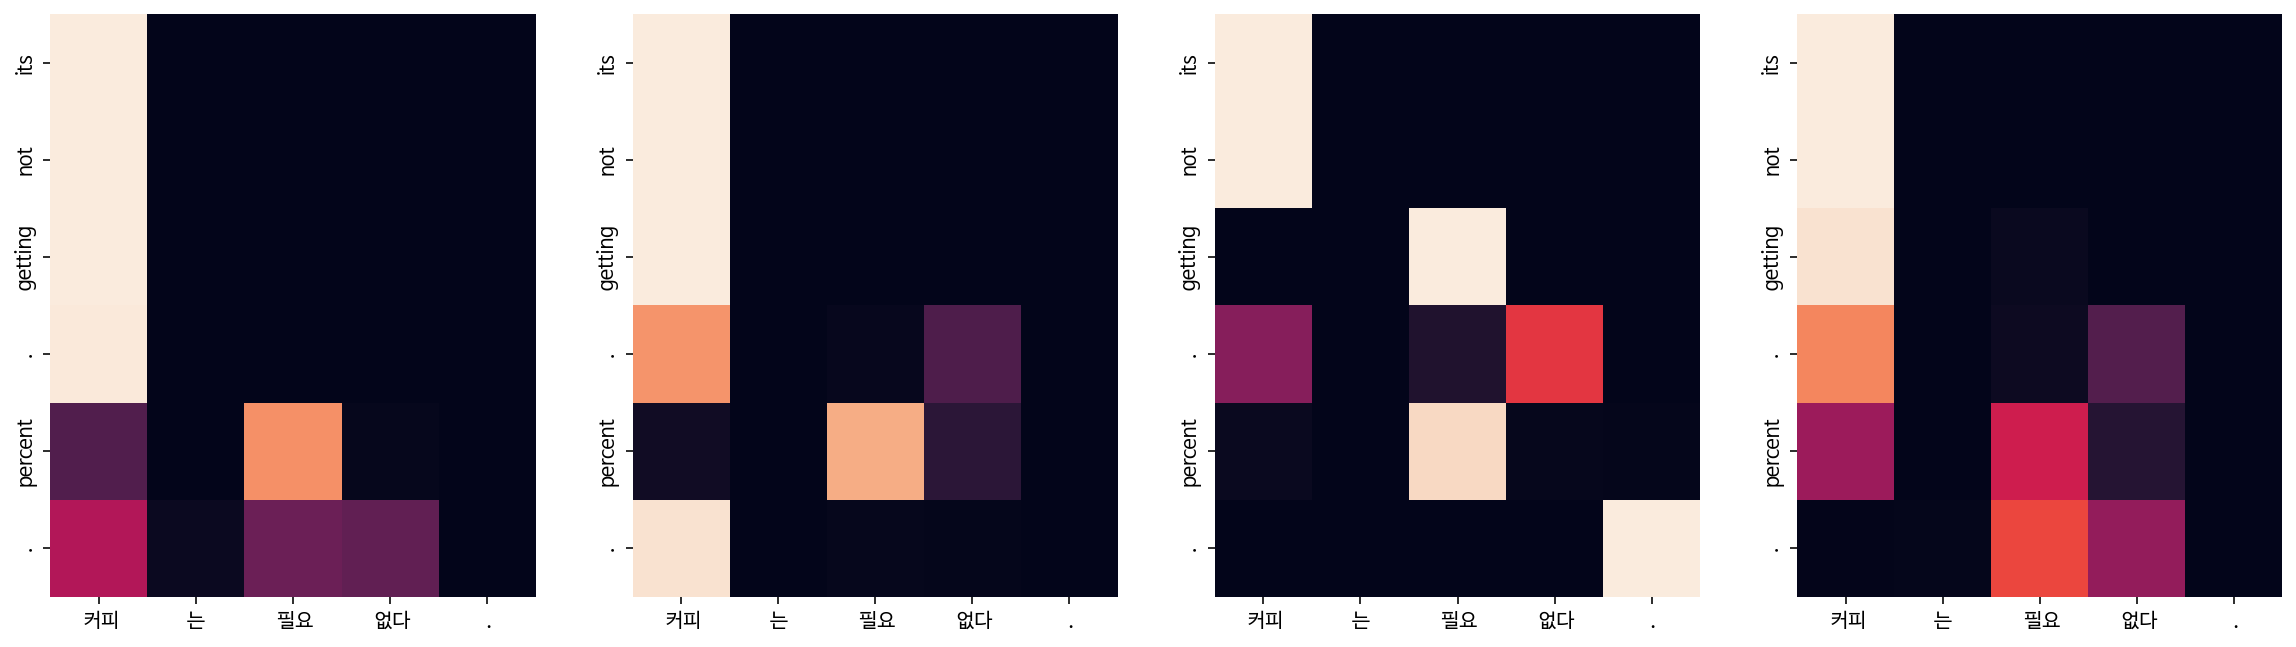



입력 문장: 일곱 명의 사망자가 발생했다.
출력 문장: the seven people died monday in the record , seven of the seven victim .
Encoder Layer 1


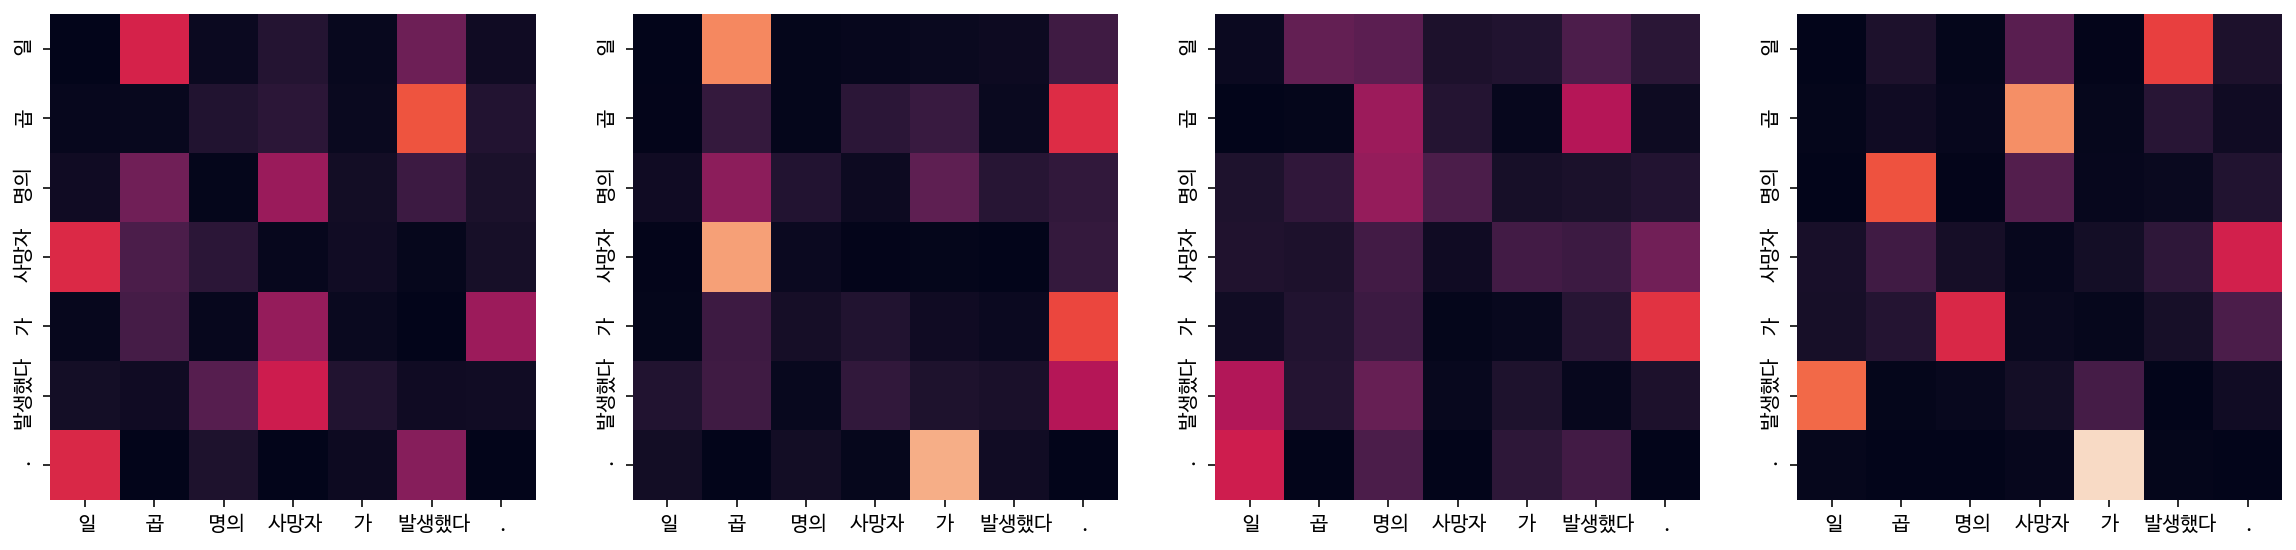

Encoder Layer 2


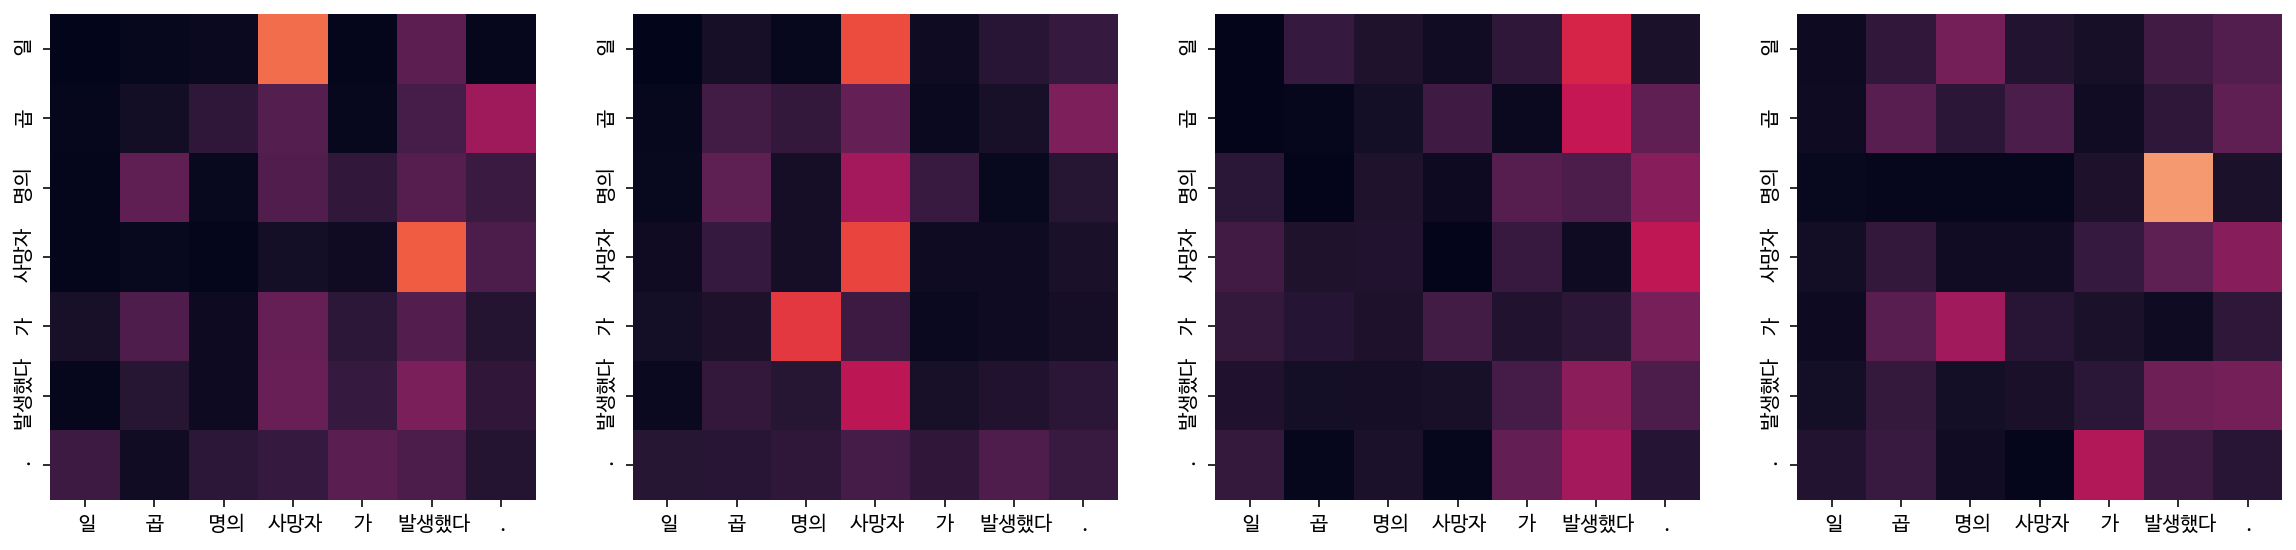

Decoder Self Layer 1


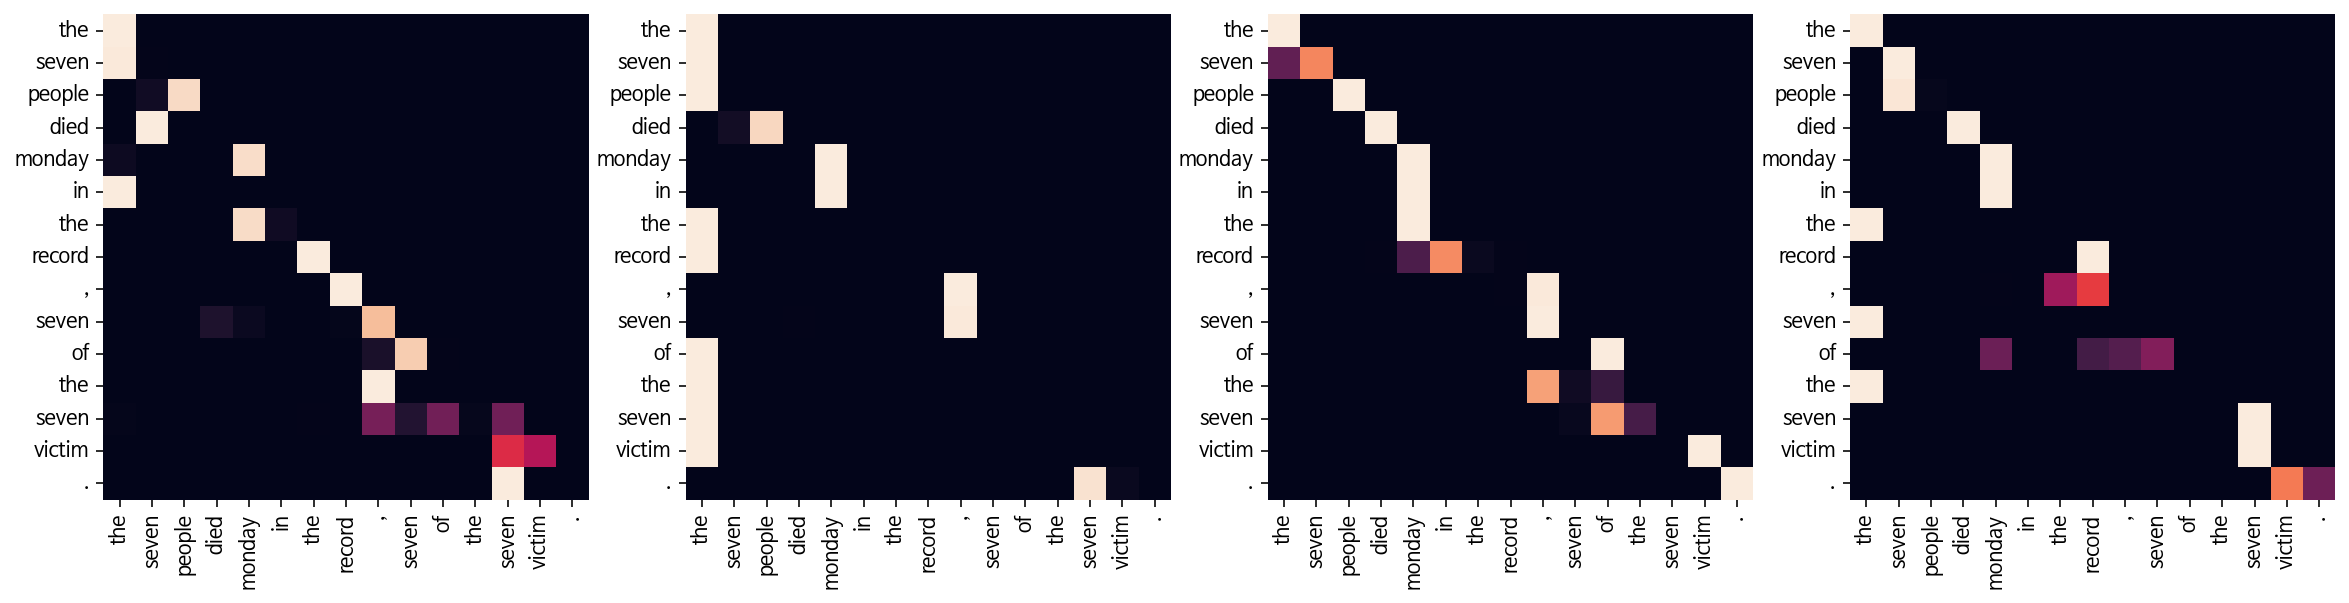

Decoder Src Layer 1


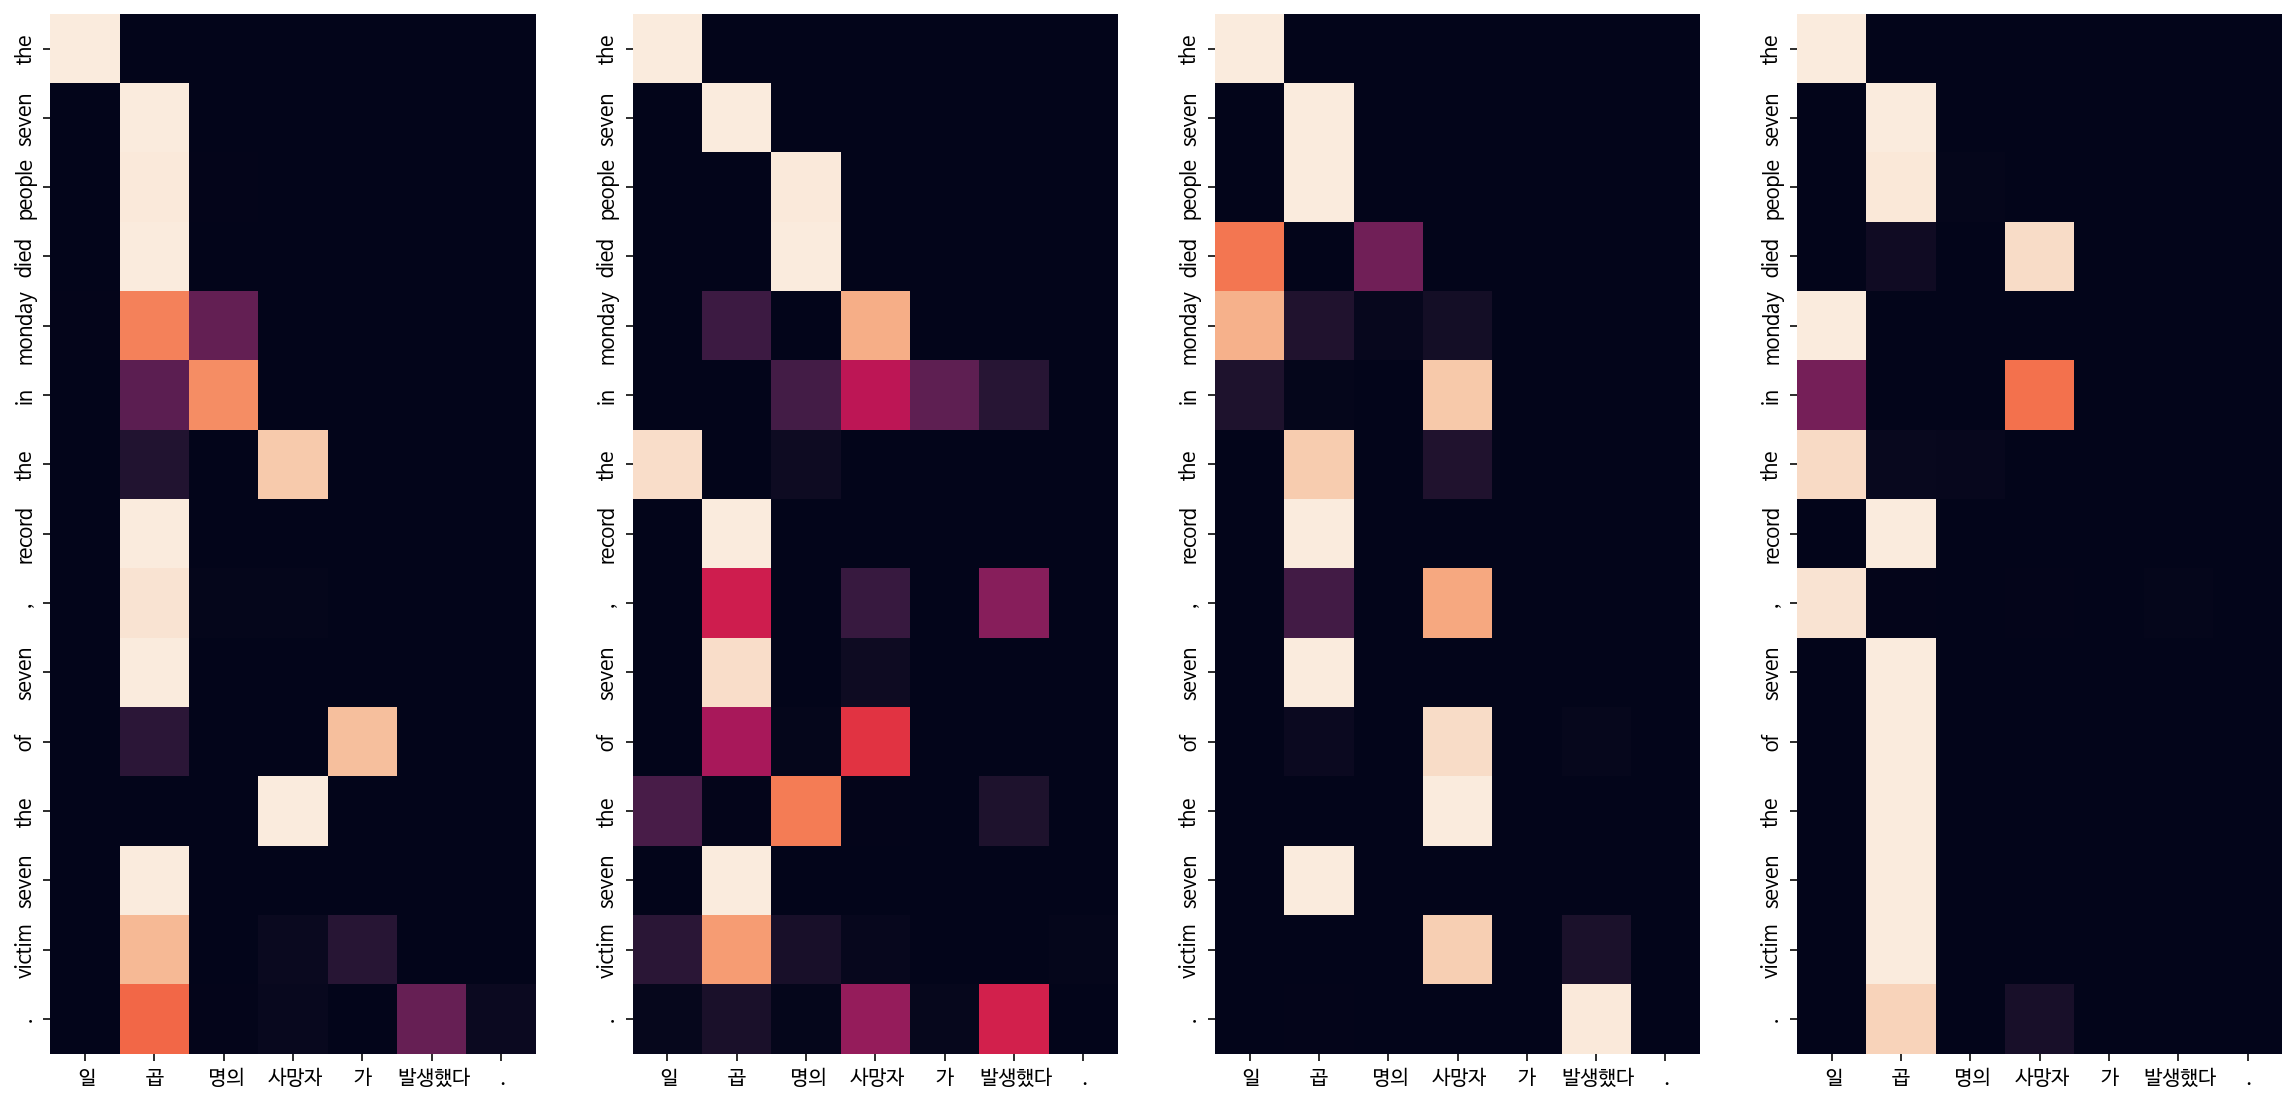

Decoder Self Layer 2


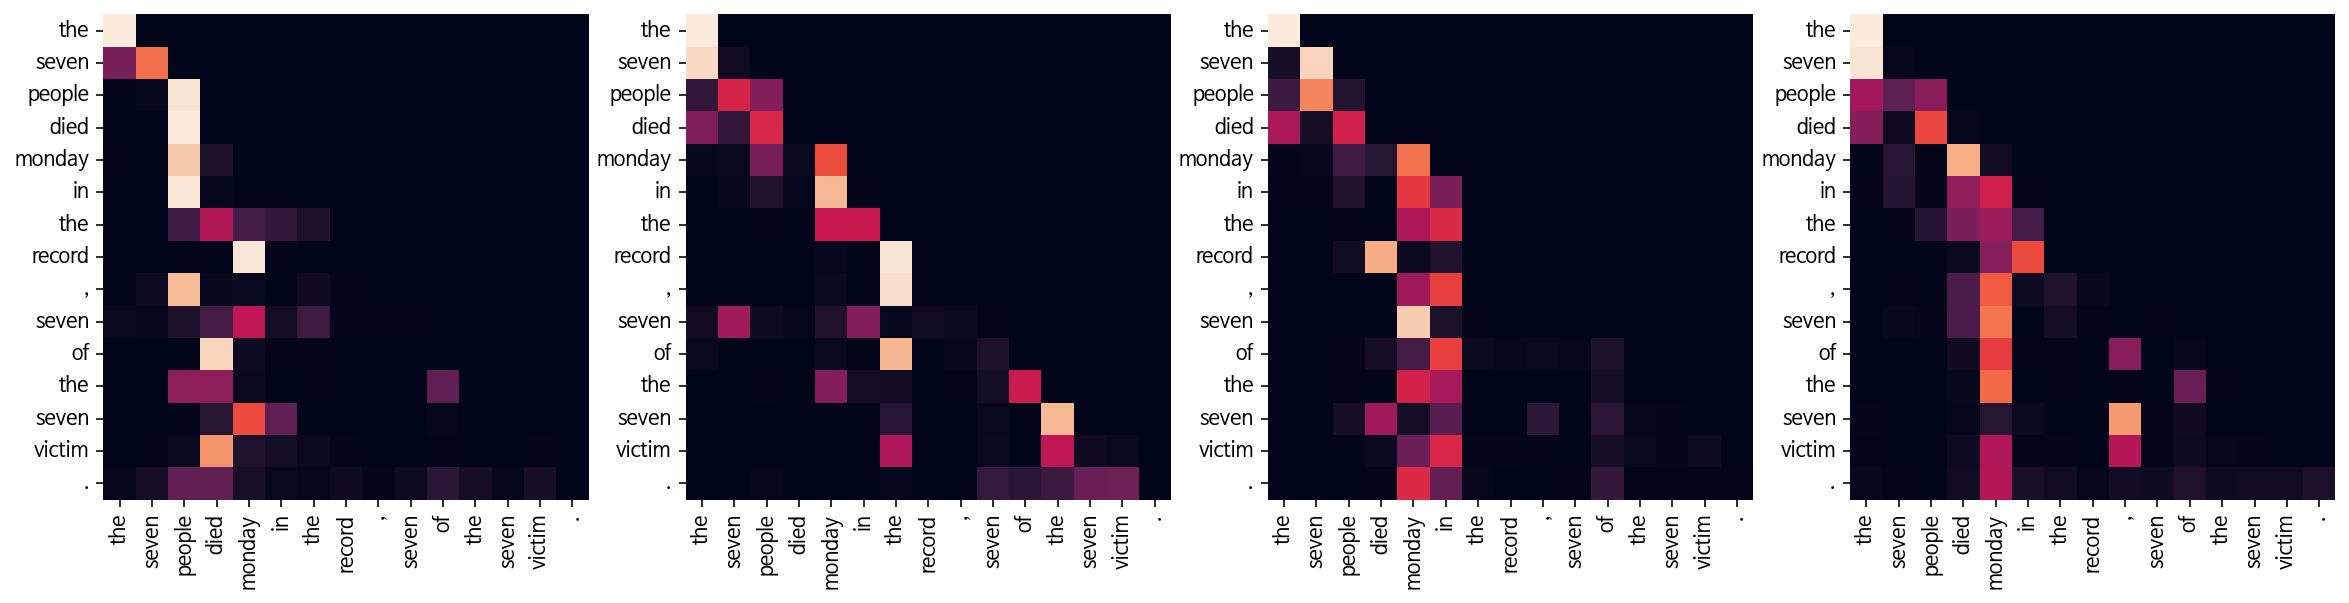

Decoder Src Layer 2


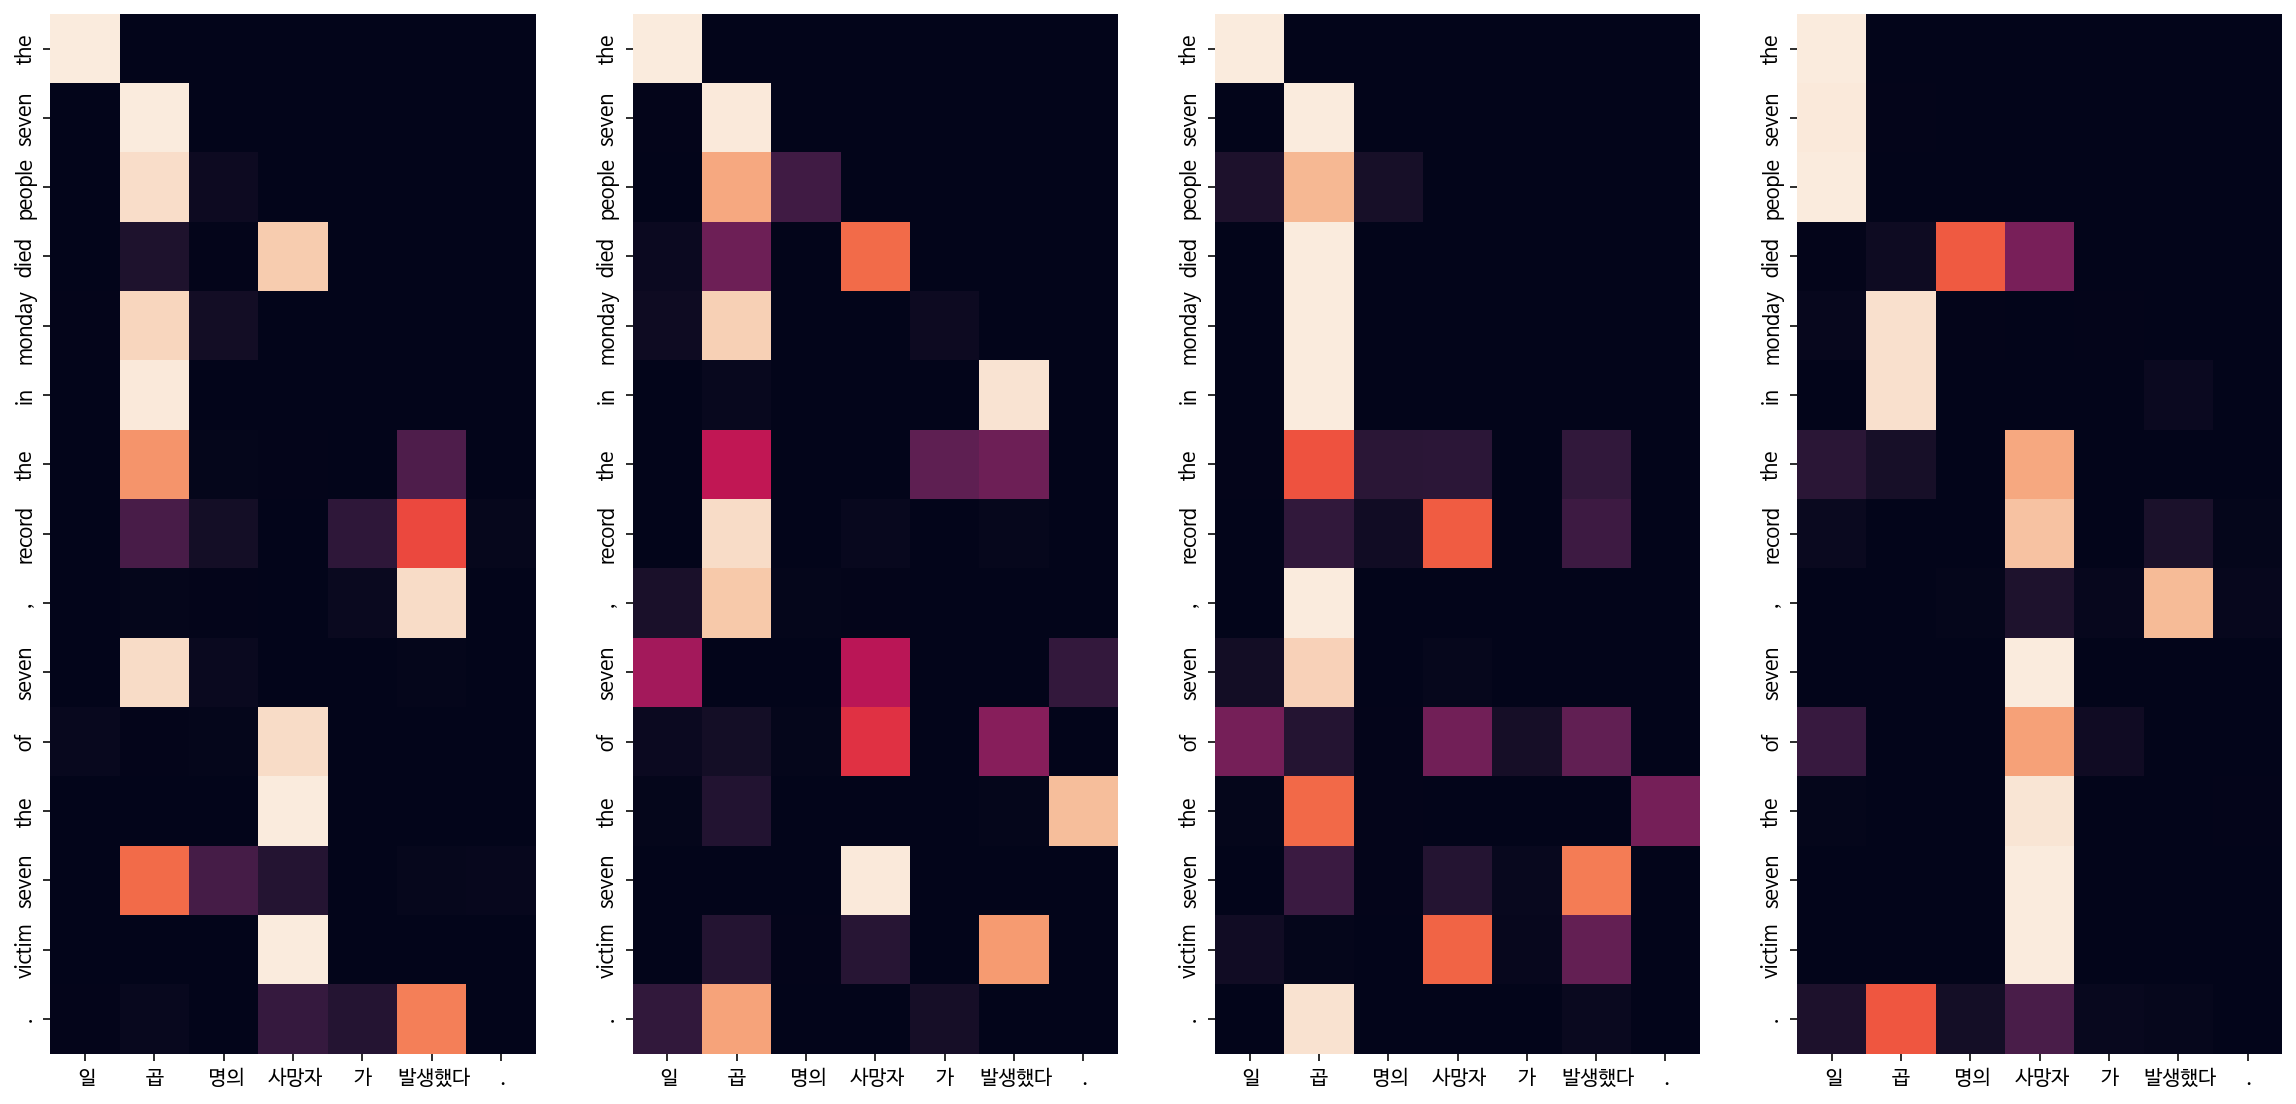



입력 문장: 오늘 오전 태평양 인근에서 비행기 한대가 추락했다.
출력 문장: in near the pacific , just one just crashed and one just friday , just before the plane .
Encoder Layer 1


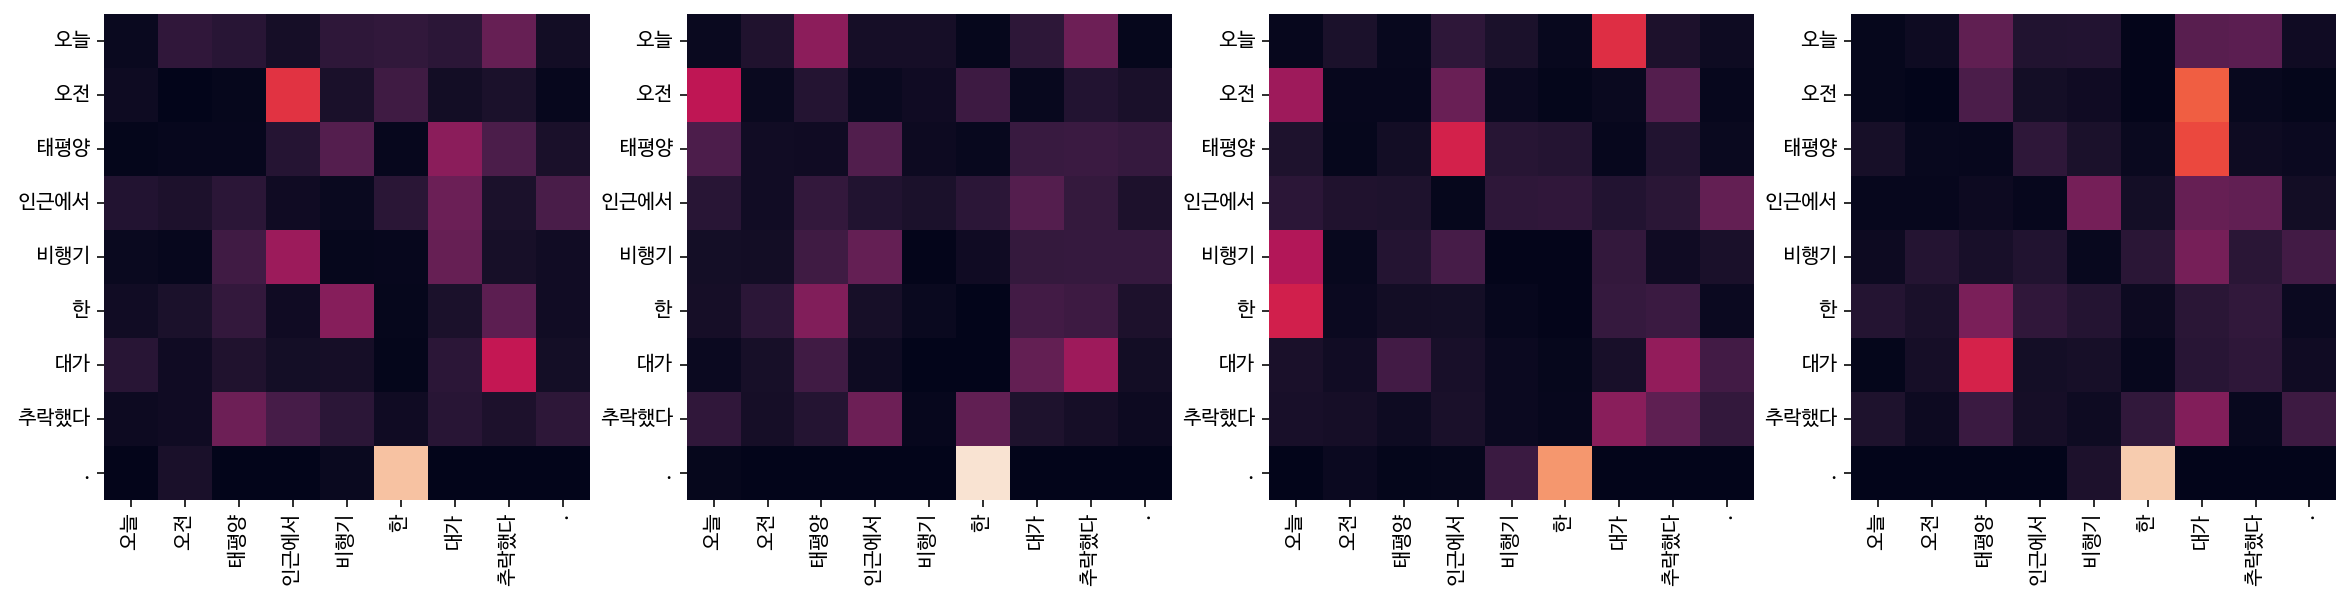

Encoder Layer 2


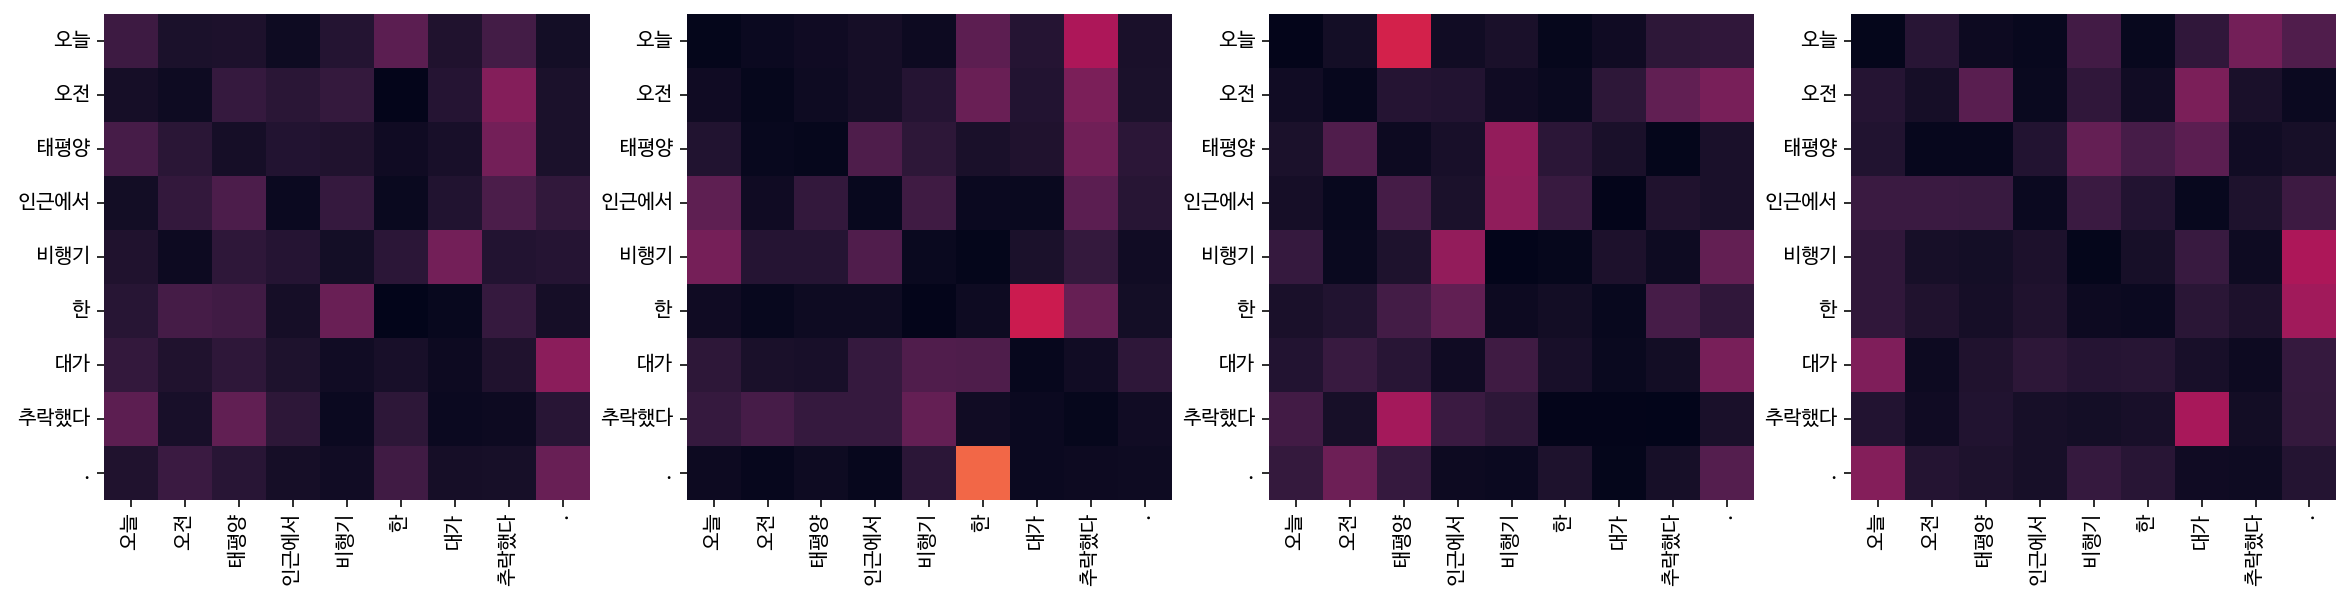

Decoder Self Layer 1


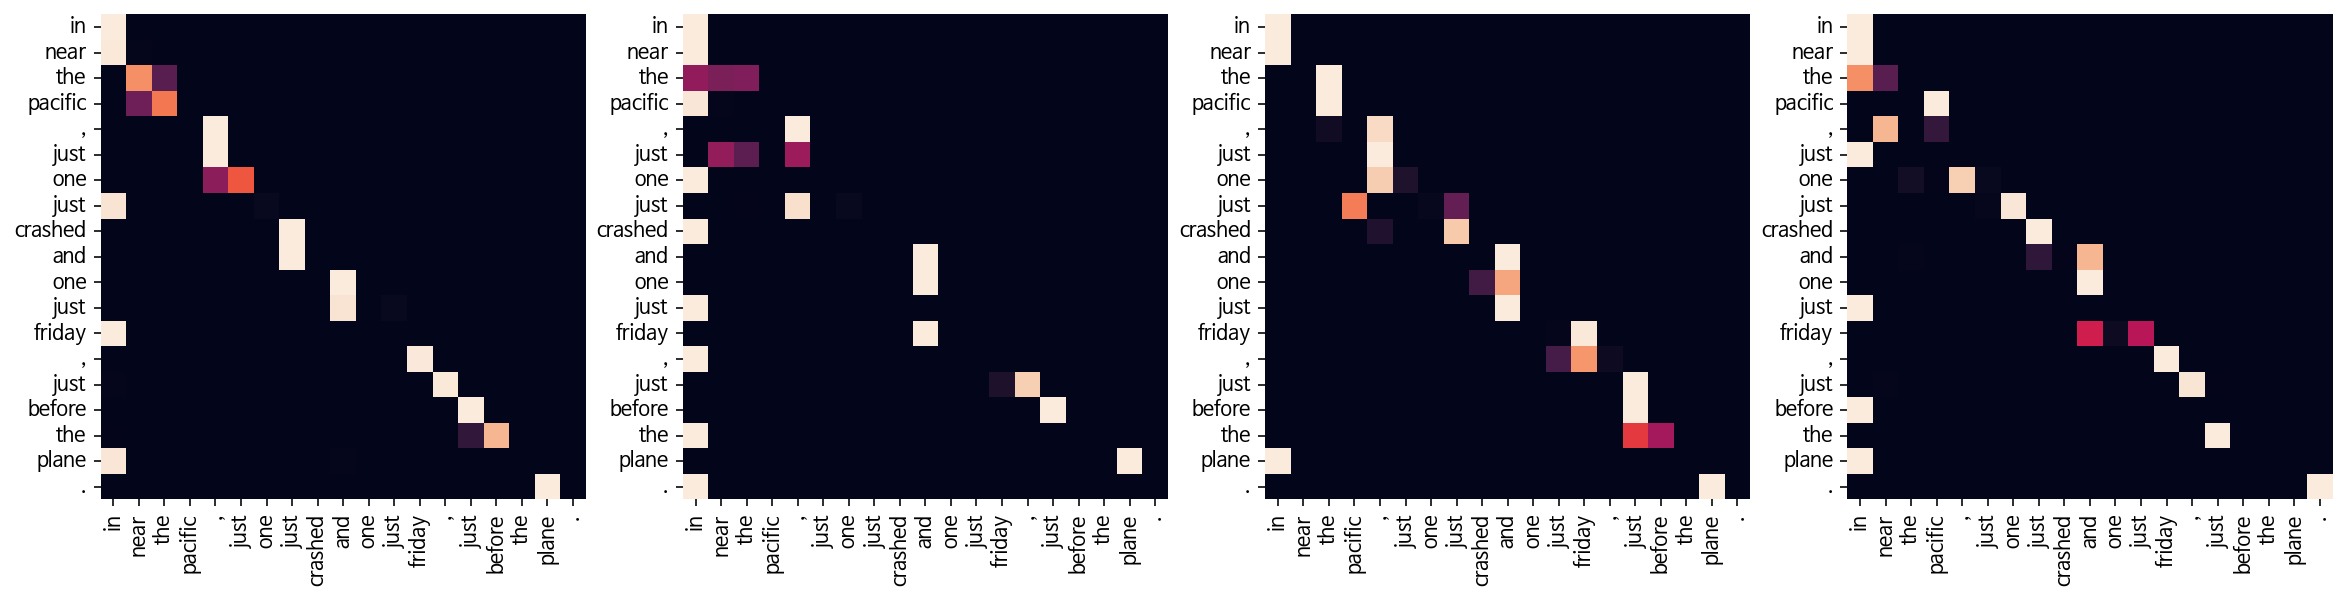

Decoder Src Layer 1


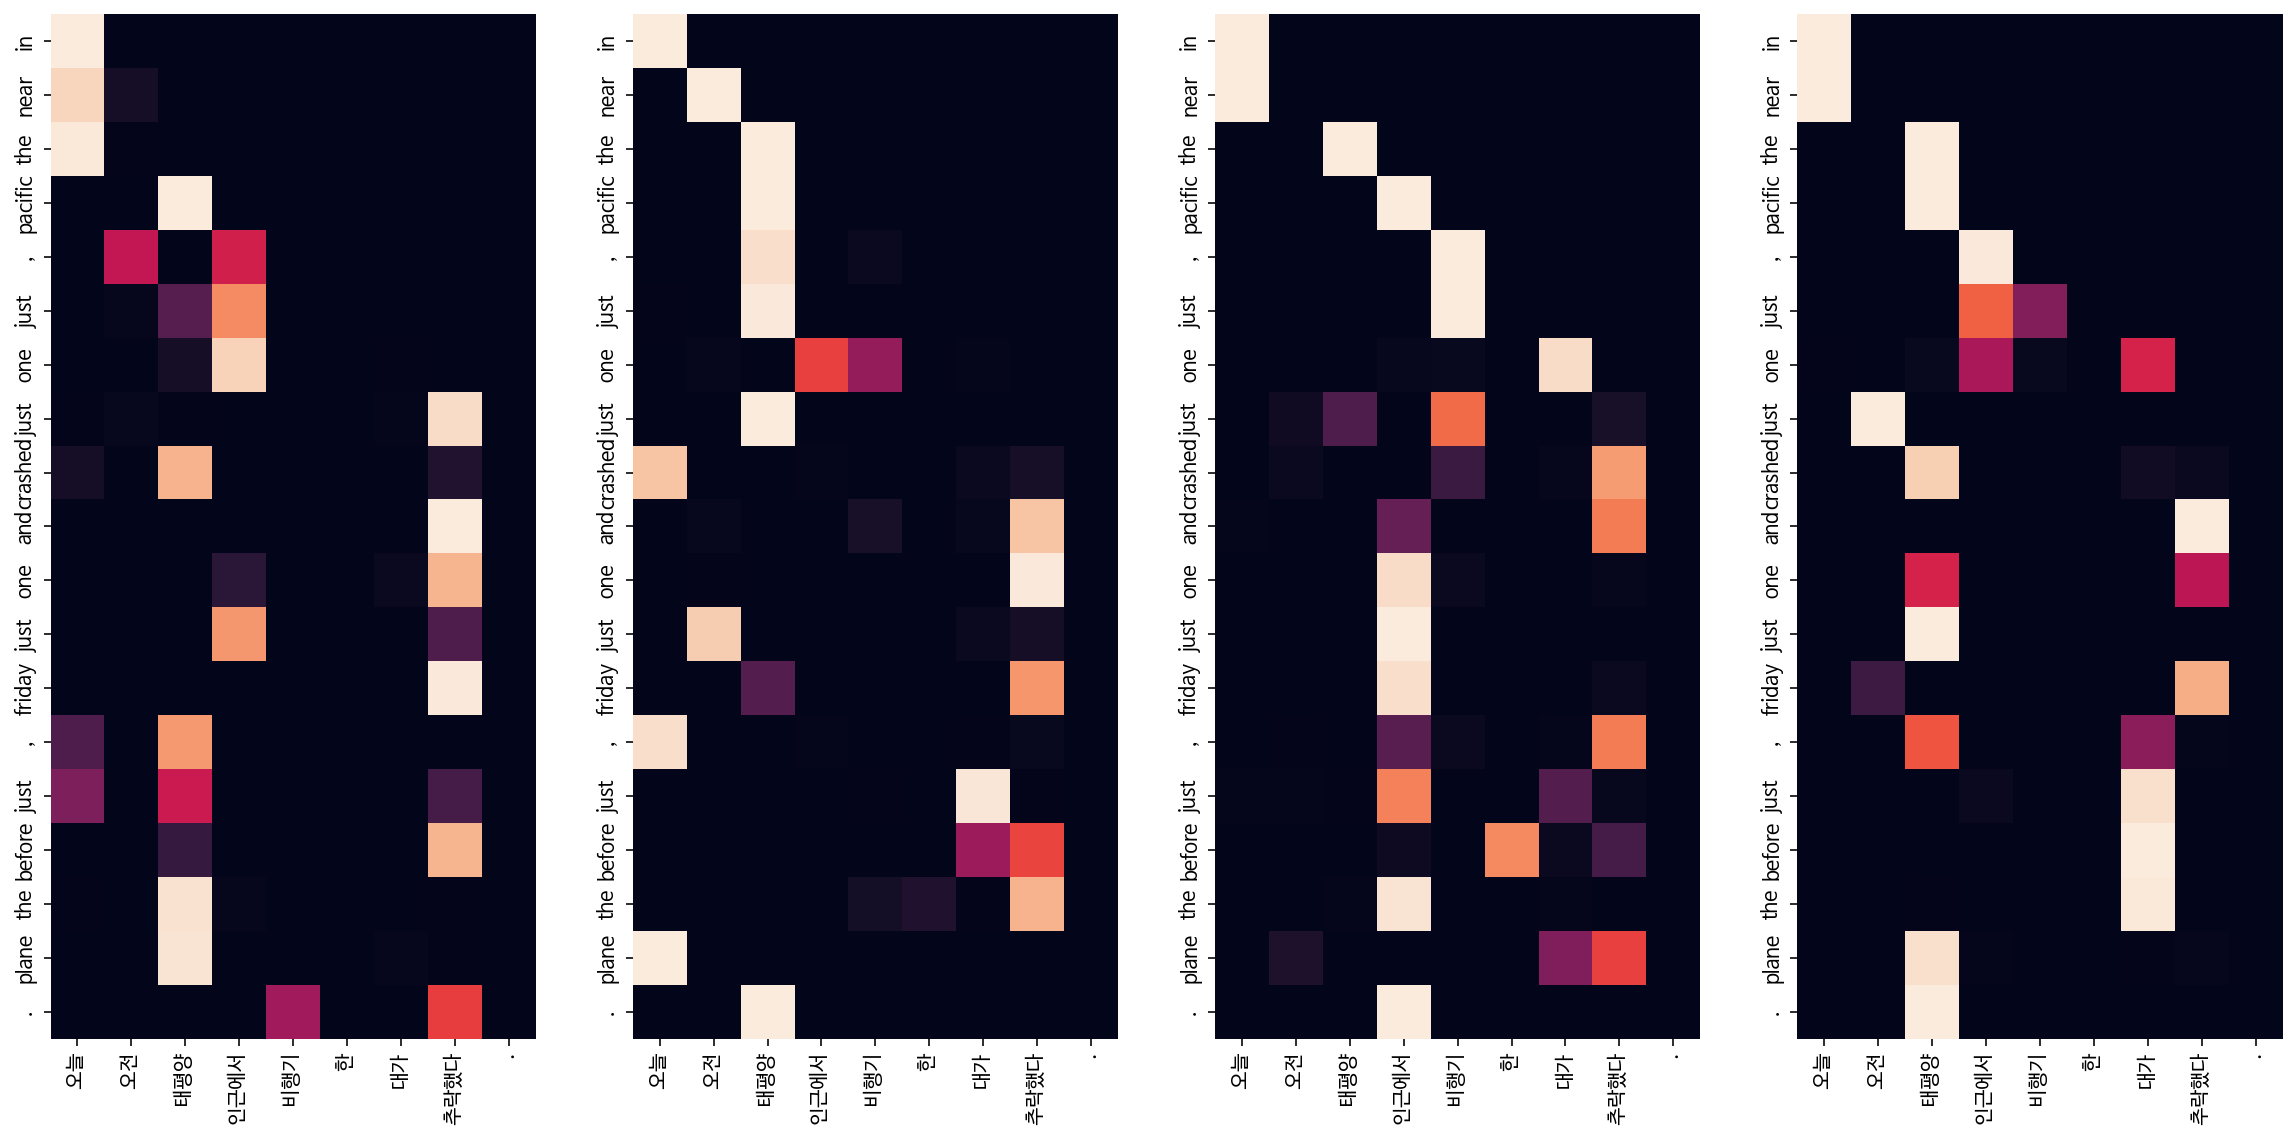

Decoder Self Layer 2


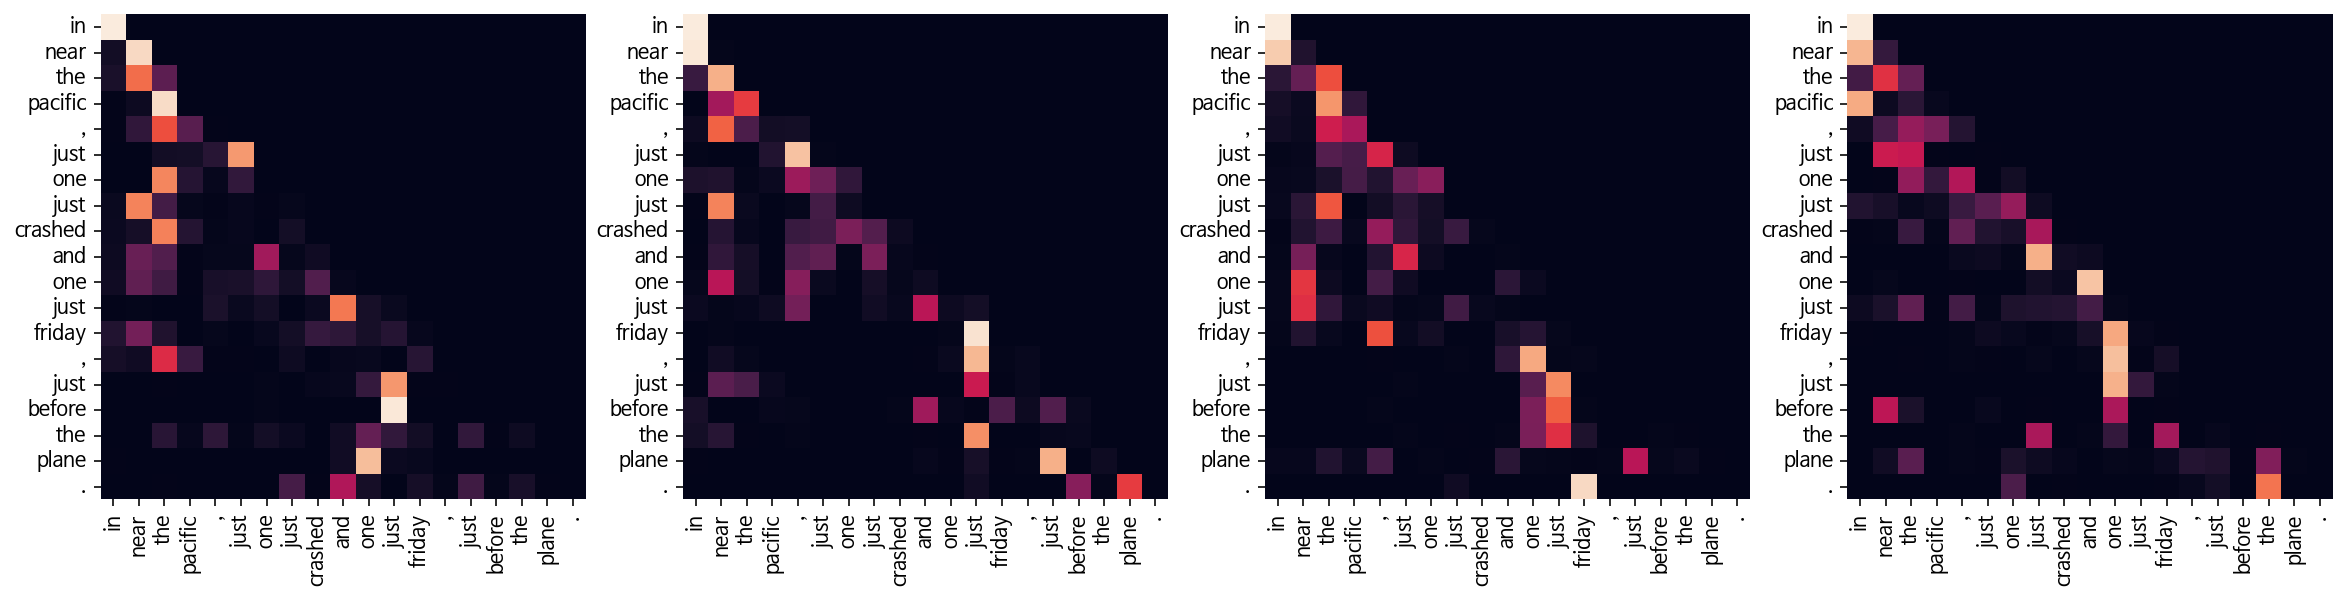

Decoder Src Layer 2


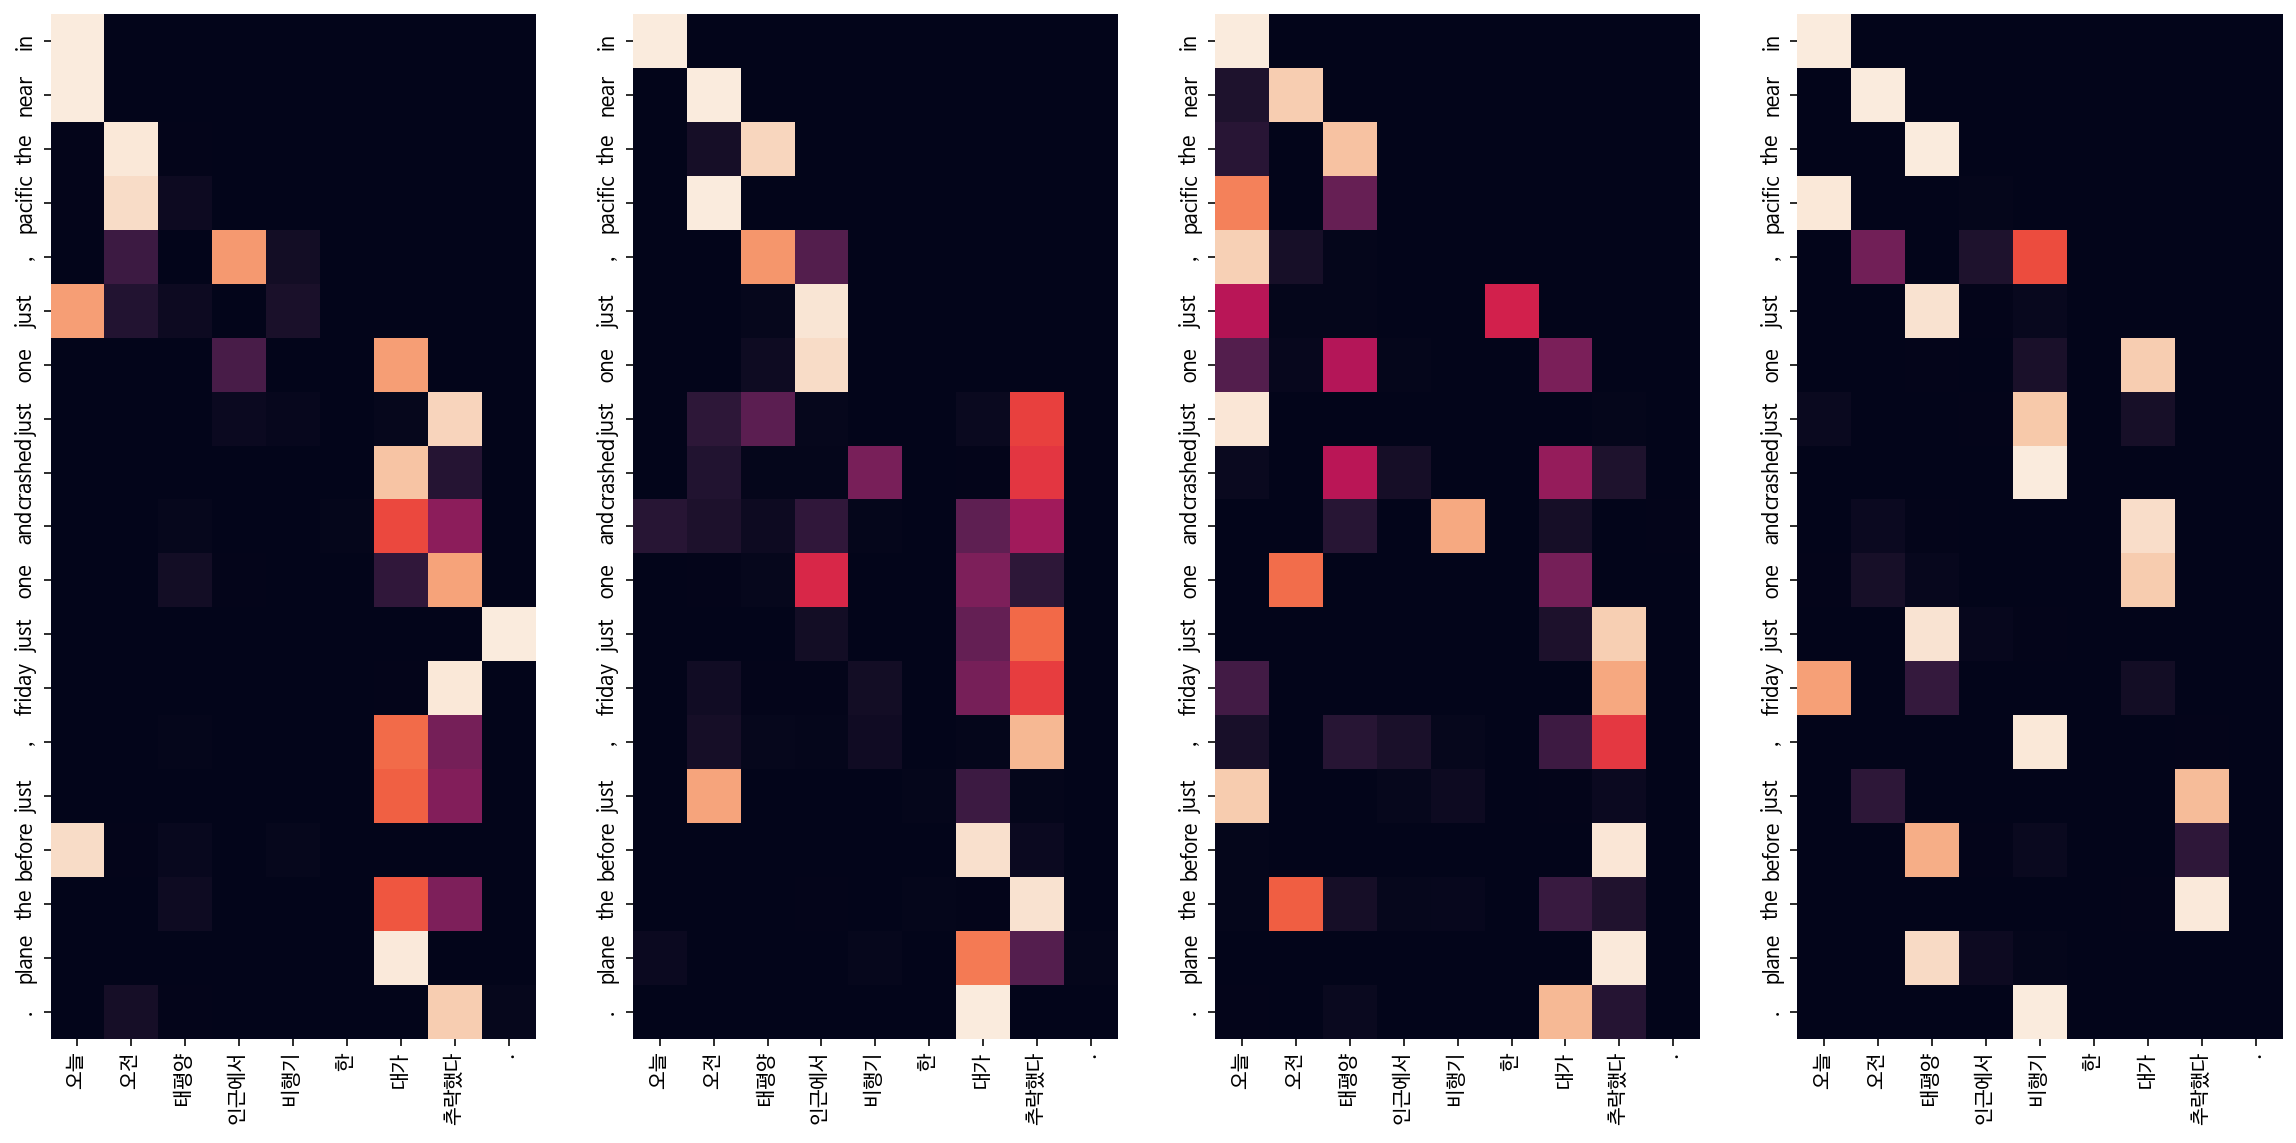

In [85]:
from tqdm import tqdm_notebook 

plot = False

hyper_parameter() 

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_corpus.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(kor_corpus[idx:idx+BATCH_SIZE],
                    eng_corpus[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    if (epoch+1) % 1 == 0:
        for example in examples:
            if (epoch+1) == EPOCHS: plot=True
            translate(example, transformer, ko_s, en_s, plot)

|Hyper Parameter|features|Layer Parameter|features|
|------|---|---|---|
|Vocab Size|15000|Num heads|4|
|Units|256|Num Layers|2|
|Batch Size|16|Positional Length|45|
|Epochs|10|D model|1024|
|d_ff|4096|Warmup Steps|4000|

|입력 문장|예문 번역|예측 문장|예측 번역|
|------|---|---|---|
|오바마는 대통령이다.|obama is the president elect .|obama is president. president. is a obama. president. president .|오바마는 대통령이다. 대통령. 오바마입니다. 대통령. 대통령 .|
|시민들은 도시 속에 산다.|they are in the city .|the beach is in town of on every day and a where parts of the town in far , the city where parts of the town in control of the town .|해변은 매일 도시에 있으며 멀리 도시의 일부가 도시를 통제하는 도시입니다.|
|커피는 필요 없다.|they don t need to be a lot of drink .|it's not getting. percent.|되지 않습니다. 퍼센트.|
|일곱 명의 사망자가 발생했다.|seven other people have been killed in the attacks|the seven people died monday in the record , seven of the seven victim .|7명의 희생자 중 7명이 기록상 월요일에 사망했습니다.|
|오늘 오전 태평양 인근에서 비행기 한대가 추락했다.|This morning, I paid a price for the full charge.|in near the pacific , just one just crashed and one just friday , just before the plane|태평양 근처에서 방금 한 번 추락했고 한 번은 금요일 비행기 직전에 추락했습니다.|

---
## 5. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트는 이상했던게 seq2seq 모델을 사용하여 쌓았던것보다 더 성능이 안나와서 그때문에 모델을 수정하느라고 굉장히 어려웠습니다. 특히 수식을 보면서 그걸 근거로 수정을 하면서 분석했는데도 성능 향상이 이루어지지 않아 많이 어려웠습니다.

### 이번 프로젝트에서 학습한 내용
>- 특히나 트랜스포머를 공부하면서 수식 등 수학에 관한 내용에 꽤나 강해진것 같습니다. 마크다운으로 수식 쓰는법이나 수식 읽는법, 계산법 등 수학적인 내용을 많이 공부하였습니다.

### 알아낸 점이나 모호한 점
>- 트랜스포머 구조에 대해서 상당히 공부를 했다고 생각하지만 아직도 파라미터들의 의미를 정확하게 파악하지는 못한것같습니다. 어림짐작은 되지만 그걸 토대로 진행해보면 그에 상응하는 성능을 보여주지 않았고 아직 트랜스포머에 대한 공부가 미흡한듯 합니다.

### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1.데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.__ 는 위에서 하였듯이 SentencePiece가 정상적으로 작동하였으며 토큰화, 데이터셋 정제 등 모두 잘 이루어 졌습니다.
>- __2. Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.__ 한영 번역기능은 잘 작동하나 성능은 기대한만큼에 미치지 못했습니다.
>- __3. 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.__ 예문 5문장중 3문장에서 나름 유의미하며 특정 단어를 추출하는 결과를 보여주었으나 나머지 2문장은 제대로 번역하지 못한것을 볼 수 있습니다.

### 루브릭 평가지표를 달성하지 못했다면 이유
>- 만약 달성하지 못했다면 2번 루브릭이 아닐까 싶습니다. 한영 번역기능이 물론 작동은 하나.. 이것이 정확한 트랜스포머의 학습, 추론 과정에서 정상적으로 진행된것인지 성능이 너무 안나와서 의문이 생겼습니다.

---
## 6. Reference

- [Attention Is All You Need 논문](https://ar5iv.labs.arxiv.org/html/1706.03762)

## 7. 자기다짐 및 아쉬운 점

- 이번 프로젝트는 시간을 굉장히 많이 쏟았음에도 불구하고 성능이 제대로 안나온것이 좀 아쉽습니다.
    
    
- 그래도 이번 프로젝트를 통해서 트랜스포머 구조에 대한 이해가 많이 되었고 앞으로 PoC 프로젝트에서도 사용하게 될 모델인데 공부를 많이 할 수 있어서 좋았습니다.
    
    
- 더욱 공부하여서 모델을 더 가다듬을 수 있는 수준이 될 수 있도록 노력해야겠습니다.